<h1>Classic aminoacids</h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import re
import requests
from bs4 import BeautifulSoup

import time


In [2]:
from rdkit import Chem
from rdkit.Chem import Descriptors

In [3]:
from collections import Counter

<h2>Cancer PPD</h2>

<h3>Dataset</h3>

In [4]:
with open('cancerppd.txt', 'r') as parser:
    lines = list(parser.readlines())

norm_lines =[]
for l in lines:
    

    if l.find('IC50') != -1:
        norm_lines.append(l)
        continue

    elif l.find('LC50') != -1:
        norm_lines.append(l)
        continue

    elif l.find('LD50') != -1:
        norm_lines.append(l)
        continue

    elif l.find('50%') != -1:
        norm_lines.append(l)
        continue

    elif l.find('50 %') != -1:
        norm_lines.append(l)
        continue

len(norm_lines), len(lines)


(2777, 3548)

In [5]:
#id db seq len topology stereo nterm cterm cell_line ic50 units ss_bridges

s = '4276 None 2004 lRRllRRllRRl DL6R6 12 Linear Mix None Free Free Antimicrobial, Antifungal and Anticancer Synthetic Peptide CL-1 Tumor MTT/MTS assay LC50>100 µM Not Available Pancreatic None AU_2004_246909_A1 CGGGHHHHCTTC'

def parse_id(s):
    return s.split()[0]

def parse_seq(s):
    if s.split()[1].find(',') == -1:
        return s.split()[3]
    else:
        return s.split()[4]

def parse_len(s):
    return len(parse_seq(s))

def parse_topology(s):
    ll = s.split()
    for el in ll:
        if el == 'Cyclic':
            return 'Cyclic'
    return 'Linear'

def parse_stereo(s):
    seq = parse_seq(s)

    if seq.upper():
        return 'L'
    elif seq.lower():
        return 'D'
    else:
        return 'Mix'
    
def parse_cterm(s):
    ll = s.split()
    flag_num = 0
    for i in  range(len(ll)):
        el = ll[i]
        if el == 'L' or el=='D' or el=='Mix':
            flag_num = i+2

    return ll[flag_num]

def parse_nterm(s):
    ll = s.split()
    flag_num = 0
    for i in  range(len(ll)):
        el = ll[i]
        if el == 'L' or el=='D' or el=='Mix':
            flag_num = i+3

    return ll[flag_num]


In [6]:
cell_lines = []
with open('cancerppd_cell_lines.txt','r') as cancerppd_cell_lines:
    cell_lines_strings = list(cancerppd_cell_lines.readlines())

for s in cell_lines_strings:
    cell_lines.append(s.split()[0])

def parse_cell_line(s):
    ll = s.replace('Not Available', '').split('Anti')[-1]
    lll = ll.split()
    for cl in cell_lines:
        for el in lll:
            if el == cl:
                return el

In [7]:
def parse_ic50(s):

    if s.find(' at ') !=-1:
        #general replacements
        s = s.replace('±', ' ').replace('=', ' = ').replace('>', '').replace('<', '').replace('~', '').replace('µ', ' µ').replace('μ', ' μ')
        slist = s.split()

        for el in range(len(slist)):
            if slist[el] == 'at':
                
                ans = slist[el+1]

                if ans.find('-') !=-1:
                    ansl = ans.split('-')
                    ans = sum([float(d) for d in ansl])/len(ansl) 


                return float(ans)


    elif s.find('=') != -1:
        
        #general replacements
        s = s.replace('±', ' ').replace('=', ' = ').replace('>', '').replace('<', '').replace('~', '')
        
        #ad hoc replacements
        s= s.replace('373.3/', '373.3')
        
        slist = s.split()

        for el in range(len(slist)):
            if slist[el].find('=') != -1:
                
                ans = slist[el+1]

                if ans.find('-') !=-1:
                    ansl = ans.split('-')
                    ans = sum([float(d) for d in ansl])/len(ansl) 

                return float(ans)


    elif s.find('>') != -1:
        #general replacements
        s = s.replace('±', ' ').replace('>>', '>').replace('>', ' > ').replace('~', '')
        slist = s.split()

        for el in range(len(slist)):
            if slist[el] == '>':
                
                ans = slist[el+1]

                if ans.find('-') !=-1:
                    ansl = ans.split('-')
                    ans = sum([float(d) for d in ansl])/len(ansl) 

                return float(ans)
            

    elif s.find('<') != -1:
        #general replacements
        s = s.replace('±', ' ').replace('<', ' < ').replace('~', '')
        slist = s.split()

        for el in range(len(slist)):
            if slist[el] == '<':
                
                ans = slist[el+1]

                if ans.find('-') !=-1:
                    ansl = ans.split('-')
                    ans = sum([float(d) for d in ansl])/len(ansl) 

                return float(ans)

            
    

    

def parse_units(s):
    s = s.replace('µ', ' µ').replace('μ', ' μ')
    slist = s.split()

    for el in slist:
        if el.find('µ') != -1:
            return el
        elif el.find('μ') !=-1:
            return el
        elif el == 'mg/L':
            return el
        elif el == 'M':
            return el
        elif el == 'mM':
            return el
        
    return 'microM'


In [8]:
def parse_ss_bridges(s):
    slist = s.split()
    for el in slist:
        if el.find('Cyclic(') != -1:
            return el[7:-1]
        
    return None

In [9]:
# testing functions
import collections
testlist = []
for l in norm_lines:
    testlist.append(parse_nterm(l))


collections.Counter(testlist)


Counter({'Free': 2424,
         'Acetylation': 309,
         'Beta-alanine': 32,
         'Biotinylated': 6,
         'CH3(CH2)10CO': 2,
         'CH3(CH2)12CO': 2,
         'CH3(CH2)14CO': 2})

In [10]:
#id db seq len topology stereo nterm cterm cell_line ic50 units ss_bridges
entries_list = []
for l in norm_lines:
    entrie = [None]*12
    entrie[0] = parse_id(l)
    entrie[1] = 'CancerPPD'
    entrie[2] = parse_seq(l)
    entrie[3] = parse_len(l)
    entrie[4] = parse_topology(l)
    entrie[5] = parse_stereo(l)
    entrie[6] = parse_nterm(l)
    entrie[7] = parse_cterm(l)
    entrie[8] = parse_cell_line(l)
    entrie[9] = parse_ic50(l)
    entrie[10] = parse_units(l)
    entrie[11] = parse_ss_bridges(l)
    entries_list.append(entrie)

ppd_df_natural = pd.DataFrame(entries_list, columns=['id', 
                                                     'db', 
                                                     'seq', 
                                                     'len', 
                                                     'topology', 
                                                     'stereo', 
                                                     'nterm', 
                                                     'cterm', 
                                                     'cell_line', 
                                                     'ic50', 
                                                     'units', 
                                                     'ss_bridge'])

ppd_df_natural

,id,db,seq,len,topology,stereo,nterm,cterm,cell_line,ic50,units,ss_bridge
0,1001,CancerPPD,FLPLLAGLAANFLPTIICKISYKC,24,Linear,L,Free,Free,A-549,6.49,µg/ml,C18-C24
1,1009,CancerPPD,FLPLLAGLAANFLPTIICKISYKC,24,Linear,L,Free,Free,293,5.62,µg/ml,C18-C24
2,1017,CancerPPD,FLPLLAGLAANFLPTIICKISYKC,24,Linear,L,Free,Free,293,5.75,µg/ml,C18-C24
3,1025,CancerPPD,FLPLLAGLAANFLPTIICKISYKC,24,Linear,L,Free,Free,Hep3B,4.91,µg/ml,C18-C24
4,1033,CancerPPD,FLPLLAGLAANFLPTIICKISYKC,24,Linear,L,Free,Free,MCF-7,4.88,µg/ml,C18-C24
...,...,...,...,...,...,...,...,...,...,...,...,...
2772,4350,CancerPPD,NYQWVPYQGRVPYPRGGLLkLLKklLKKLlKL,32,Linear,L,Free,Free,SU.86.86,7.90,µM,None
2773,4351,CancerPPD,GRVPYPRGGLLkLLKklLKKLlKL,24,Linear,L,Free,Free,BxPC-3,14.70,µM,None
2774,4352,CancerPPD,GRVPYPRGGLLkLLKklLKKLlKL,24,Linear,L,Free,Free,CFPAC-I,9.20,µM,None
2775,4353,CancerPPD,GRVPYPRGGLLkLLKklLKKLlKL,24,Linear,L,Free,Free,Pane-,14.10,µM,None


<h3>SMILES</h3>

In [22]:
!pip install git+https://github.com/Boehringer-Ingelheim/pyPept.git

  Cloning https://github.com/Boehringer-Ingelheim/pyPept.git to /tmp/pip-req-build-4ewzil8c
  Running command git clone --filter=blob:none --quiet https://github.com/Boehringer-Ingelheim/pyPept.git /tmp/pip-req-build-4ewzil8c
  Resolved https://github.com/Boehringer-Ingelheim/pyPept.git to commit ade9f5840691ad1f8fa22d13939a665c25175d5a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 307.5 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.2/34.2 MB 727.1 kB/s eta 0:00:0000:0100:02
  Created wheel for pyPept: filename=pyPept-1.0.0-py3-none-any.whl size=174447 sha256=924a0fbfc8cd7c1e3c5b6f908e1e92cd14e1e7a7549583bb5d4a2ab3eeac284b
  Stored in directory: /tmp/pip-ephem-wheel-cache-cfe7d9_4/wheels/70/66/b9/20cfc9a9168702fa251aa3897facd7d4efd39b2ad92bae1c55
Successfully built pyPept


In [32]:
ppd_df_natural['nterm'].value_counts()

nterm
Amidation        2016
Free              757
Methoxylation       4
Name: count, dtype: int64

In [33]:
ppd_df_natural['cterm'].value_counts()

cterm
Free            2424
Acetylation      309
Beta-alanine      32
Biotinylated       6
CH3(CH2)10CO       2
CH3(CH2)12CO       2
CH3(CH2)14CO       2
Name: count, dtype: int64

In [4]:
# PyPept modules
from pyPept.sequence import Sequence
from pyPept.sequence import correct_pdb_atoms
from pyPept.molecule import Molecule
from pyPept.converter import Converter
from pyPept.conformer import Conformer
from pyPept.conformer import SecStructPredictor

# RDKit modules
from rdkit import Chem
from rdkit.Chem import Draw


In [ ]:
#for canonical L and D aa 
def calc_smiles_classic(seq, nterm='Free', cterm='Free', topology='Linear',ss_bridge=None):

    ### BILN

    #add -
    seq1 = '-'.join(list(seq))
    #replacement for D aminoacids
    seq2 = seq1.replace('d', 'dD').replace('a', 'dA').replace('c', 'dC').replace('e', 'dE')
    seq2 = seq2.replace('f', 'dF').replace('g', 'G').replace('h', 'dH').replace('i', 'dI')
    seq2 = seq2.replace('k', 'dK').replace('l', 'dL').replace('m', 'dM').replace('n', 'dN')
    seq2 = seq2.replace('p', 'dP').replace('q', 'dQ').replace('r', 'dR').replace('s', 'dS')
    seq2 = seq2.replace('t', 'dT').replace('v', 'dV').replace('w', 'dW').replace('y', 'dY')
    

    #ss_bridges
    if ss_bridge:
        i1 = int(ss_bridge.split('-')[0][1:])-1
        i2 = int(ss_bridge.split('-')[1][1:])-1
        tmp_list = seq2.split('-')
        tmp_list[i1] = 'C(1,3)'
        tmp_list[i2] = 'C(1,3)'
        seq2 = '-'.join(tmp_list)
    


    
    #c-terminus
    c_terminal = ''
    if cterm in ('Amidation', 'AMD'):
        c_terminal = '-am'     

    elif cterm =='Methoxylation':
        c_terminal = '-_OMe'

    #n-terminus 
    n_terminal = ''
    n_ext = None

    if nterm in ('Acetylation', 'ACT'):
        n_terminal = 'ac-'

    elif nterm == 'Beta-alanine':
        n_terminal = 'bAla-'        

    elif nterm == 'Biotinylated':
        n_terminal = 'Bua-'
        n_ext = 'Biotinylated'

    elif nterm == 'CH3(CH2)10CO':
        n_terminal = 'Bua-'
        n_ext = 'CH3(CH2)10CO'
    
    elif nterm in ('CH3(CH2)12CO'):
        n_terminal = 'Bua-'
        n_ext = 'CH3(CH2)12CO'
    
    elif nterm == 'CH3(CH2)14CO':
        n_terminal = 'Bua-'
        n_ext = 'CH3(CH2)14CO'

    #topology
    if topology == 'Cyclic':
        seq2 = seq2.replace('-', '(1,1)-', 1)
        seq2 += '(1,2)'
            
    #smiles
    biln = n_terminal + seq2 + c_terminal

    #print(biln)
    

    sq = Sequence(biln)
    sq = correct_pdb_atoms(sq)
    mol = Molecule(sq, depiction='local')
    romol = mol.get_molecule(fmt='ROMol')

    smiles = Chem.MolToSmiles(romol)

    #n-terminal decorations 
    if n_ext=='CH3(CH2)10CO':
        smiles = smiles.replace('CCCC(=O)', 'CCCCCCCCCCCC(=O)',1)

    elif n_ext == 'CH3(CH2)12CO':
        smiles = smiles.replace('CCCC(=O)', 'CCCCCCCCCCCCCC(=O)',1)

    elif n_ext == 'CH3(CH2)12CO':
        smiles = smiles.replace('CCCC(=O)', 'CCCCCCCCCCCCCCCC(=O)',1)

    elif n_ext == 'Biotinylated':
        smiles = smiles.replace('CCCC(=O)', 'C1CC2NSNC2C1CCCCCC(=O)',1)

    

    return smiles


In [6]:
calc_smiles_classic('FFFF', nterm='Biotinylated')

'C1CC2NSNC2C1CCCCCC(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccccc1)C(=O)O'

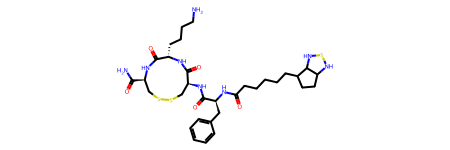

In [ ]:
Chem.MolFromSmiles(calc_smiles_classic('FCKC', nterm='Biotinylated', cterm='Amidation', ss_bridge='C2-C4'))

In [124]:
ppd_df_natural['smiles'] = ppd_df_natural.apply(lambda row: calc_smiles_classic(row['seq'],
                                                                                row['nterm'],
                                                                                row['cterm'],
                                                                                row['topology'],
                                                                                row['ss_bridge']), axis=1)
ppd_df_natural

,id,db,seq,len,topology,stereo,nterm,cterm,cell_line,ic50,units,ss_bridge,smiles
0,1001,CancerPPD,FLPLLAGLAANFLPTIICKISYKC,24,Linear,L,Free,Free,A-549,6.49,µg/ml,C18-C24,CC[C@H](C)[C@@H]1NC(=O)[C@H](CCCCN)NC(=O)[C@@H...
1,1009,CancerPPD,FLPLLAGLAANFLPTIICKISYKC,24,Linear,L,Free,Free,293,5.62,µg/ml,C18-C24,CC[C@H](C)[C@@H]1NC(=O)[C@H](CCCCN)NC(=O)[C@@H...
2,1017,CancerPPD,FLPLLAGLAANFLPTIICKISYKC,24,Linear,L,Free,Free,293,5.75,µg/ml,C18-C24,CC[C@H](C)[C@@H]1NC(=O)[C@H](CCCCN)NC(=O)[C@@H...
3,1025,CancerPPD,FLPLLAGLAANFLPTIICKISYKC,24,Linear,L,Free,Free,Hep3B,4.91,µg/ml,C18-C24,CC[C@H](C)[C@@H]1NC(=O)[C@H](CCCCN)NC(=O)[C@@H...
4,1033,CancerPPD,FLPLLAGLAANFLPTIICKISYKC,24,Linear,L,Free,Free,MCF-7,4.88,µg/ml,C18-C24,CC[C@H](C)[C@@H]1NC(=O)[C@H](CCCCN)NC(=O)[C@@H...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2772,4350,CancerPPD,NYQWVPYQGRVPYPRGGLLkLLKklLKKLlKL,32,Linear,L,Free,Free,SU.86.86,7.90,µM,None,CC(C)C[C@H](NC(=O)[C@H](CCCCN)NC(=O)[C@@H](CC(...
2773,4351,CancerPPD,GRVPYPRGGLLkLLKklLKKLlKL,24,Linear,L,Free,Free,BxPC-3,14.70,µM,None,CC(C)C[C@H](NC(=O)[C@H](CCCCN)NC(=O)[C@@H](CC(...
2774,4352,CancerPPD,GRVPYPRGGLLkLLKklLKKLlKL,24,Linear,L,Free,Free,CFPAC-I,9.20,µM,None,CC(C)C[C@H](NC(=O)[C@H](CCCCN)NC(=O)[C@@H](CC(...
2775,4353,CancerPPD,GRVPYPRGGLLkLLKklLKKLlKL,24,Linear,L,Free,Free,Pane-,14.10,µM,None,CC(C)C[C@H](NC(=O)[C@H](CCCCN)NC(=O)[C@@H](CC(...


In [126]:
def calc_wt_from_smiles(sm):
    mol = Chem.MolFromSmiles(sm)
    molecular_mass = Descriptors.MolWt(mol)
    return molecular_mass

ppd_df_natural['molwt'] = ppd_df_natural['smiles'].apply(calc_wt_from_smiles)


<Axes: >

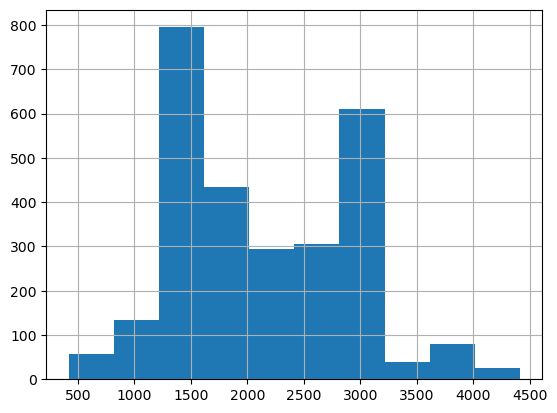

In [127]:
ppd_df_natural['molwt'].hist()

In [128]:
ppd_df_natural['units'].value_counts()

units
µg/ml     1210
µM         820
µMol/L     323
µMo/L      208
M          142
mM          55
μM          13
microM       3
mg/L         2
µg0/ml       1
Name: count, dtype: int64

In [124]:
'''
CancerPPD Dataset
units
µg/ml     1210+
µM         820+
µMol/L     323+
µMo/L      208+
M          142
mM          55+
μM          13+
microM       3+
mg/L         2+
µg0/ml       1+
'''
'''
DBAASP
units
µM       119+
µg/ml     65+
'''
'''
dbAMP3
units
microM    2301
µg/ml      751
'''
def calc_ic50_adjusted(ic50, units, molwt):

    # right units: microgram/mL = mg/L
    if units in ('µg/ml', 'mg/L', 'µg0/ml', 'µM', 'µg/ml','µg/ml'):
        return ic50
    

    # microMol/L
    elif units in ('µM', 'µMol/L', 'µMo/L', 'μM', 'microM'):
        return (ic50*molwt)/1000
    
    # mM = miliM
    elif units == 'mM':
        return ic50*molwt
    
    # M
    elif units == 'M':
        return ic50*molwt*1000
    
ppd_df_natural['ic50_microg/ml'] = ppd_df_natural.apply(lambda row: calc_ic50_adjusted(row['ic50'],
                                                                                       row['units'],
                                                                                       row['molwt']),
                                                                                       axis=1)
ppd_df_natural['ic50_microg/ml'].hist()

NameError: name 'ppd_df_natural' is not defined

In [132]:
ppd_df_natural.columns

Index(['id', 'db', 'seq', 'len', 'topology', 'stereo', 'nterm', 'cterm',
       'cell_line', 'ic50', 'units', 'ss_bridge', 'smiles', 'molwt',
       'ic50_microg/ml'],
      dtype='object')

In [139]:
new_ppd_df_natural = ppd_df_natural.drop(columns=['units', 'ic50']).drop_duplicates()
new_ppd_df_natural.shape


(2245, 13)

In [141]:
new_ppd_df_natural.to_csv('./preprocessed_datasets/cancerppd_unmodified_regression.csv', index=False)

In [11]:
new_ppd_df_natural['cell_line'].unique()

NameError: name 'new_ppd_df_natural' is not defined

<h2>DBAASP</h2>

<h3>Dataset</h3>

In [33]:
dbaasp = pd.read_csv('dbaasp.csv', index_col=0)
dbaasp.head()

,id,nterm,seq,cterm,target,mod,db,len,stereo,pdb,topology,comments
47,102,NaN,ALWKTLLKKVLKAAAKAALKAVLVGANA,NaN,Staphylococcus aureus MIC 1-4 µg/ml Escherichi...,NaN,DBAASP,28,L,NaN,Linear,NaN
90,146,NaN,KRIVQRIKDFLR,NaN,HIV IC50 REP >63.5 µM Acinetobacter baumannii ...,NaN,DBAASP,12,L,NaN,Linear,NaN
103,160,NaN,VRRFPWWWPFLRR,NaN,Aspergillus fumigatus MIC 250 µg/ml Escherich...,NaN,DBAASP,13,L,NaN,Linear,NaN
138,197,NaN,KKLFKKILKYL,AMD,Xanthomonas campestris pv. Vesicatoria 2133-2 ...,NaN,DBAASP,11,L,NaN,Linear,NaN
170,230,NaN,KWKLFKKIPKFLHLAKKF,AMD,Pseudomonas aeruginosa MIC 25 µg/ml Acinetobac...,NaN,DBAASP,18,L,NaN,Linear,NaN


In [ ]:
dbaasp.drop(columns=['comments', 'pdb'], inplace=True)

In [35]:
dbaasp['nterm'] = dbaasp['nterm'].fillna('Free')
dbaasp['cterm'] = dbaasp['cterm'].fillna('Free')
dbaasp['mod'] = dbaasp['mod'].fillna('Free')
dbaasp.head()

,id,nterm,seq,cterm,target,mod,db,len,stereo,topology
47,102,Free,ALWKTLLKKVLKAAAKAALKAVLVGANA,Free,Staphylococcus aureus MIC 1-4 µg/ml Escherichi...,Free,DBAASP,28,L,Linear
90,146,Free,KRIVQRIKDFLR,Free,HIV IC50 REP >63.5 µM Acinetobacter baumannii ...,Free,DBAASP,12,L,Linear
103,160,Free,VRRFPWWWPFLRR,Free,Aspergillus fumigatus MIC 250 µg/ml Escherich...,Free,DBAASP,13,L,Linear
138,197,Free,KKLFKKILKYL,AMD,Xanthomonas campestris pv. Vesicatoria 2133-2 ...,Free,DBAASP,11,L,Linear
170,230,Free,KWKLFKKIPKFLHLAKKF,AMD,Pseudomonas aeruginosa MIC 25 µg/ml Acinetobac...,Free,DBAASP,18,L,Linear


In [36]:
dbaasp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73 entries, 47 to 987
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        73 non-null     int64 
 1   nterm     73 non-null     object
 2   seq       73 non-null     object
 3   cterm     73 non-null     object
 4   target    73 non-null     object
 5   mod       73 non-null     object
 6   db        73 non-null     object
 7   len       73 non-null     int64 
 8   stereo    73 non-null     object
 9   topology  73 non-null     object
dtypes: int64(2), object(8)
memory usage: 6.3+ KB


In [37]:
dbaasp['target'].value_counts()

target
Staphylococcus aureus MIC 1-4 µg/ml Escherichia coli MIC 1-16 µg/ml Leishmania major (promastigote) LC50 1.5 µM Staphylococcus aureus B38302 MIC 2±1 µM Escherichia coli MG1655 MIC 0.19 µg/ml Pseudomonas aeruginosa PAO1 MIC 0.39 µg/ml HSV-2 EC50 2.10 µM Acinetobacter baumannii MIC 3.125 µg/ml Human epidermoid cancer Hep2 50% Cytotoxicity 75.71 µg/ml Human cervical carcinoma HeLa 50% Cytotoxicity 37.39 µg/ml Escherichia coli MG1655 83% Inhibition 0.38 µg/ml Pseudomonas aeruginosa PAO1 83% Inhibition 0.78 µg/ml Human erythrocytes 50% Hemolysis 0.5±0.2 µM Human microglial cells HMC3 50% Cytotoxicity 20.89 µg/ml                                                                                                                                                                                                                                                                                                                                                                                           

In [287]:
def separator(s):
    measures = ('µg/ml', 'µM','NA')
    for m in measures:
        s = s.replace(m, m+'|')
    l = s.split('| ')

    # dicrimination of non-relevant experiments
    l = [x for x in l if (x.find('MIC') == -1 and x.find('Hemolysis') == -1 and x.find('NA')==-1 and x.find('MBC') == -1)]
    l = [x for x in l if (x.find('HIV') == -1 and x.find('Candida') == -1 and x.find('Escherichia')==-1 and x.find('acillus') == -1)]
    l = [x for x in l if (x.find('Pseudomonas') == -1 and x.find('coccus') == -1 and x.find('Trichostrongylus')==-1 and x.find('bacter') == -1)]
    l = [x for x in l if (x.find('Zebrafish') == -1 and x.find('Leishmania') == -1 and x.find('Plasmodium')==-1 and x.find('Serratia') == -1)]
    l = [x for x in l if (x.find('HSV') == -1 and x.find('Paramecium') == -1 and x.find('monas')==-1 and x.find('virus') == -1)]
    l = [x for x in l if (x.find('Klebsiella') == -1 and x.find('Listeria') == -1 and x.find('Aspergillus')==-1 and x.find('MFC') == -1)]
    l = [x for x in l if (x.find('Euglena') == -1 and x.find('Trypanosoma') == -1 and x.find('MEC')==-1 and x.find('LC ')==-1)]  
    #   
    l = [x for x in l if any([x.find('IC50') != -1, x.find('LC50') != -1, x.find('LD50') != -1, x.find('EC50') != -1, x.find('ED50') != -1, x.find('50%') !=-1])]                                            

    return l

targetlines = dbaasp['target']
targetlines = [separator(x) for x in targetlines]
targetlines


[['Human epidermoid cancer Hep2 50% Cytotoxicity 75.71 µg/ml',
  'Human cervical carcinoma HeLa 50% Cytotoxicity 37.39 µg/ml',
  'Human microglial cells HMC3 50% Cytotoxicity 20.89 µg/ml|'],
 ['CEM-SS cells 50% cell death >63.5 µM'],
 ['Human breast adenocarcinoma MDA-MB-361 IC50 142 µg/ml',
  'Mouse fibroblasts NIH 3T3 IC50 145 µg/ml',
  'Human PBMC IC50 40.6 µM'],
 ['Human breast adenocarcinoma MCF-7 IC50 27.6±3.0 µM',
  'Human myelogenous leukemia K562 IC50 30.4±2.7 µM',
  'Human pancreatic adenocarcinoma CAPAN-1 IC50 57.7±13.3 µM',
  'Human hepatocellular carcinoma HepG2 IC50 27.9±3.1 µM',
  'Human gastric epithelial cells GES-1 IC50 57.9±5.2 µM',
  'Mouse fibroblasts NIH 3T3 IC50 62.5±6.4 µM'],
 ['Human myelogenous leukemia K562 IC50 8.28 µM',
  'Human breast adenocarcinoma MDA-MB-361 IC50 8.0 µM',
  'Human myelogenous leukemia K562 IC50 3.5 µM',
  'Mouse fibroblasts NIH 3T3 IC50 75.0 µM|'],
 ['Human prostate carcinoma 22RV1 LC50 6 µM',
  'Human breast adenocarcinoma MDA-MB-231 LC

In [288]:
dbaasp['target'] = dbaasp['target'].apply(separator)

In [289]:
dbaasp = dbaasp.explode('target').dropna(subset=['target'])
dbaasp

,id,nterm,seq,cterm,target,mod,db,len,stereo,topology
47,102,Free,ALWKTLLKKVLKAAAKAALKAVLVGANA,Free,Human epidermoid cancer Hep2 50% Cytotoxicity ...,Free,DBAASP,28,L,Linear
47,102,Free,ALWKTLLKKVLKAAAKAALKAVLVGANA,Free,Human cervical carcinoma HeLa 50% Cytotoxicity...,Free,DBAASP,28,L,Linear
47,102,Free,ALWKTLLKKVLKAAAKAALKAVLVGANA,Free,Human microglial cells HMC3 50% Cytotoxicity 2...,Free,DBAASP,28,L,Linear
90,146,Free,KRIVQRIKDFLR,Free,CEM-SS cells 50% cell death >63.5 µM,Free,DBAASP,12,L,Linear
103,160,Free,VRRFPWWWPFLRR,Free,Human breast adenocarcinoma MDA-MB-361 IC50 14...,Free,DBAASP,13,L,Linear
...,...,...,...,...,...,...,...,...,...,...
912,1026,Free,FVQWFSKFLGRIL,AMD,Human myelogenous leukemia K562 LC50 7.5-10 µM,Free,DBAASP,13,L,Linear
936,1052,Free,PFWRIRIRR,AMD,Human promyelocytic leukemia HL-60 IC50 247.62 µM,Free,DBAASP,9,L,Linear
936,1052,Free,PFWRIRIRR,AMD,Human dermal fibroblasts LC50 >100 µM,Free,DBAASP,9,L,Linear
985,1104,Free,GEILCNLCTGLINTLENLLTTKGADKVKDYISSLCNKASGFIATLC...,Free,Human histiocytic lymphoma U-937 LC50 80 µM,5 77 DSB SSB CST 35 46 DSB SSB CST,DBAASP,77,L,Linear


In [290]:
def get_cell_line(s):
    
    measurements = ('IC50','LC50', 'LD50', 'EC50', 'ED50', '50%')
    for m in measurements:
        s=s.replace(m, '|')
        
    return s.split('|')[0].strip()

dbaasp['cell_line'] = dbaasp['target'].apply(get_cell_line)


In [291]:
dbaasp['cell_line'].unique()

array(['Human epidermoid cancer Hep2', 'Human cervical carcinoma HeLa',
       'Human microglial cells HMC3', 'CEM-SS cells',
       'Human breast adenocarcinoma MDA-MB-361',
       'Mouse fibroblasts NIH 3T3', 'Human PBMC',
       'Human breast adenocarcinoma MCF-7',
       'Human myelogenous leukemia K562',
       'Human pancreatic adenocarcinoma CAPAN-1',
       'Human hepatocellular carcinoma HepG2',
       'Human gastric epithelial cells GES-1',
       'Human prostate carcinoma 22RV1',
       'Human breast adenocarcinoma MDA-MB-231',
       'Human breast cells 2783N', 'Human colon adenocarcinoma HT29',
       'Human lung carcinoma A549', 'Human rhabdomyosarcoma',
       'Mouse skin melanoma B16', 'Human gastric cancer SGC-7901',
       'Human melanoma A375', 'Human colon adenocarcinoma SW1116',
       'Human lung carcinoma H1299', 'Human gastric adenocarcinoma AGS',
       'Human hepatocellular carcinoma Huh7',
       'Human cervical carcinoma HeLa S3',
       'Human colon adenoca

In [292]:
def get_cell_line2(s):

    l = s.split()
    if l[-1] == 'cells':
        return l[-2]
    else:
        return l[-1]
    
dbaasp['cell_line'] = dbaasp['cell_line'].apply(get_cell_line2)
dbaasp['cell_line'].unique()

array(['Hep2', 'HeLa', 'HMC3', 'CEM-SS', 'MDA-MB-361', '3T3', 'PBMC',
       'MCF-7', 'K562', 'CAPAN-1', 'HepG2', 'GES-1', '22RV1',
       'MDA-MB-231', '2783N', 'HT29', 'A549', 'rhabdomyosarcoma', 'B16',
       'SGC-7901', 'A375', 'SW1116', 'H1299', 'AGS', 'Huh7', 'S3',
       'SW480', 'PC-3', 'J774A.1', 'leukocytes', 'CCRF-CEM', 'NCI-H661',
       'RPMI-7666', 'WI-38', 'Vero', 'A498', '116', '45', 'SK-OV-3',
       'KG-1', 'ARH-77', 'SH-SY5Y', '661W', 'HEK293T', 'neutrophils',
       'MM96L', 'BGC-823', 'U-937/GTB', '(HFF)', 'HaCat', 'leukemia',
       'cancer', 'melanoma', 'carcinoma', 'A2058', 'NFF', 'C8166',
       'BIU-87', 'HEK293', 'RPMI-8226', 'NCI-H460', 'U251-MG', 'UACC-62',
       'ACHN', 'HCT-15', 'SW620', 'DU145', 'RAJI', 'SK-MEL-2', 'HL-60',
       'J5', 'Molt-4', 'fibroblasts', 'U-937'], dtype=object)

In [295]:
print(dbaasp['target'])

47     Human epidermoid cancer Hep2 50% Cytotoxicity ...
47     Human cervical carcinoma HeLa 50% Cytotoxicity...
47     Human microglial cells HMC3 50% Cytotoxicity 2...
90                  CEM-SS cells 50% cell death >63.5 µM
103    Human breast adenocarcinoma MDA-MB-361 IC50 14...
                             ...                        
912       Human myelogenous leukemia K562 LC50 7.5-10 µM
936    Human promyelocytic leukemia HL-60 IC50 247.62 µM
936                Human dermal fibroblasts LC50 >100 µM
985          Human histiocytic lymphoma U-937 LC50 80 µM
986          Human histiocytic lymphoma U-937 LC50 80 µM
Name: target, Length: 189, dtype: object


In [297]:
def get_units(s):
    
    if s.find('µg/ml') != -1:
        return 'µg/ml'
    
    elif s.find('µM') !=-1:
        return 'µM'
    

dbaasp['units'] = dbaasp['target'].apply(get_units)
dbaasp['units'].value_counts()

units
µM       122
µg/ml     67
Name: count, dtype: int64

<Axes: >

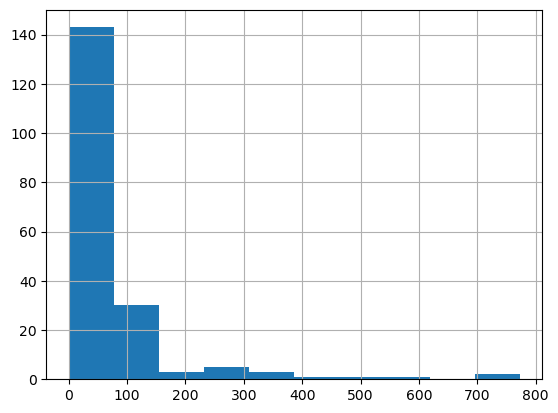

In [306]:
def get_ic50(s):
    
    measurements = ('IC50','LC50', 'LD50', 'EC50', 'ED50', '50%')
    for m in measurements:
        s=s.replace(m, '|')
        
    w = s.split('|')[1].strip()
    w = w.split()[-2]
    w = w.split('±')[0]
    w = w.split('-')[0]


    w = w.replace('>', '').replace('<', '').replace('=', '')
    return float(w)

dbaasp['ic50'] = dbaasp['target'].apply(get_ic50)
dbaasp['ic50'].hist()
    

In [307]:
dbaasp.head()

,id,nterm,seq,cterm,target,mod,db,len,stereo,topology,cell_line,units,ic50
47,102,Free,ALWKTLLKKVLKAAAKAALKAVLVGANA,Free,Human epidermoid cancer Hep2 50% Cytotoxicity ...,Free,DBAASP,28,L,Linear,Hep2,µg/ml,75.71
47,102,Free,ALWKTLLKKVLKAAAKAALKAVLVGANA,Free,Human cervical carcinoma HeLa 50% Cytotoxicity...,Free,DBAASP,28,L,Linear,HeLa,µg/ml,37.39
47,102,Free,ALWKTLLKKVLKAAAKAALKAVLVGANA,Free,Human microglial cells HMC3 50% Cytotoxicity 2...,Free,DBAASP,28,L,Linear,HMC3,µg/ml,20.89
90,146,Free,KRIVQRIKDFLR,Free,CEM-SS cells 50% cell death >63.5 µM,Free,DBAASP,12,L,Linear,CEM-SS,µM,63.50
103,160,Free,VRRFPWWWPFLRR,Free,Human breast adenocarcinoma MDA-MB-361 IC50 14...,Free,DBAASP,13,L,Linear,MDA-MB-361,µg/ml,142.00


<h3>SMILES</h3>

In [309]:
dbaasp.shape

(189, 13)

In [308]:
dbaasp['mod'].value_counts()

mod
Free                                    163
6 15 DSB SSB CST                          7
1 29 AMD MMB NCB  9 21 DSB SSB CST        6
18 24 DSB SSB CST                         5
2 15 DSB SSB CST  1 PYA GLN               4
23 28 DSB SSB CST                         2
11 18 DSB SSB CST                         1
5 77 DSB SSB CST  35 46 DSB SSB CST       1
Name: count, dtype: int64

In [314]:
values_to_delete =['2 15 DSB SSB CST  1 PYA GLN ', '5 77 DSB SSB CST  35 46 DSB SSB CST ']
dbaasp = dbaasp.drop(dbaasp[dbaasp['mod'].isin(values_to_delete)].index)
dbaasp.shape

(184, 13)

In [315]:
def topology_adj(s):
    if s.find('1 29 AMD MMB NCB') !=-1:
        return 'Cyclic'
    else:
        return 'Linear'
    
dbaasp['topology'] = dbaasp['mod'].apply(topology_adj)
dbaasp['topology'].value_counts()

topology
Linear    178
Cyclic      6
Name: count, dtype: int64

In [344]:
def get_ss_bridge(s):
    if s == 'Free':
        return None
    elif s.find('1 29 AMD MMB NCB') !=-1:
        return None
    else:
        l = s.split()
        return f'C{l[0]}-C{l[1]}'
    
dbaasp['ss_bridge'] = dbaasp['mod'].apply(get_ss_bridge)
dbaasp['ss_bridge'].value_counts()

ss_bridge
C6-C15     7
C18-C24    5
C23-C28    2
C11-C18    1
Name: count, dtype: int64

In [320]:
dbaasp['nterm'].value_counts()

nterm
Free    157
ACT      27
Name: count, dtype: int64

In [324]:
seqs = list(dbaasp['seq'])
nterms = list(dbaasp['nterm'])
cterms = list(dbaasp['cterm'])
topologies = list(dbaasp['topology'])
ss_bridges = list(dbaasp['ss_bridge'])

smiless = []
for i in range(len(seqs)):
    smiless.append(calc_smiles_classic(seqs[i], nterms[i], cterms[i], topologies[i], ss_bridges[i]))
    print(len(smiless), end='-')

1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-36-37-38-39-40-41-42-43-44-45-46-47-48-49-50-51-52-53-54-55-56-57-58-59-60-61-62-63-64-65-66-67-68-69-70-71-72-73-74-75-76-77-78-79-80-81-82-83-84-85-86-87-88-89-90-91-92-93-94-95-

TypeError: 'NoneType' object is not subscriptable

In [329]:
seqs[i], nterms[i], cterms[i], topologies[i], ss_bridges[i]

('GLPVCGETCVGGTCNTPGCTCSWPVCTRN', 'Free', 'Free', 'Cyclic', 'C9-C21')

In [343]:
calc_smiles_classic(seqs[i], nterms[i], cterms[i], topologies[i], ss_bridges[i])

G(1,1)-L-P-V-C-G-E-T-C(1,3)-V-G-G-T-C-N-T-P-G-C-T-C(1,3)-S-W-P-V-C-T-R-N(1,2)


TypeError: 'NoneType' object is not subscriptable

In [347]:
dbaasp['smiles'] = dbaasp.apply(lambda row: calc_smiles_classic(row['seq'],
                                                                row['nterm'],
                                                                row['cterm'],
                                                                row['topology'],
                                                                row['ss_bridge']), axis=1)
dbaasp

,id,nterm,seq,cterm,target,mod,db,len,stereo,topology,cell_line,units,ic50,ss_bridge,smiles
47,102,Free,ALWKTLLKKVLKAAAKAALKAVLVGANA,Free,Human epidermoid cancer Hep2 50% Cytotoxicity ...,Free,DBAASP,28,L,Linear,Hep2,µg/ml,75.71,None,CC(C)C[C@H](NC(=O)[C@H](C)N)C(=O)N[C@@H](Cc1c[...
47,102,Free,ALWKTLLKKVLKAAAKAALKAVLVGANA,Free,Human cervical carcinoma HeLa 50% Cytotoxicity...,Free,DBAASP,28,L,Linear,HeLa,µg/ml,37.39,None,CC(C)C[C@H](NC(=O)[C@H](C)N)C(=O)N[C@@H](Cc1c[...
47,102,Free,ALWKTLLKKVLKAAAKAALKAVLVGANA,Free,Human microglial cells HMC3 50% Cytotoxicity 2...,Free,DBAASP,28,L,Linear,HMC3,µg/ml,20.89,None,CC(C)C[C@H](NC(=O)[C@H](C)N)C(=O)N[C@@H](Cc1c[...
90,146,Free,KRIVQRIKDFLR,Free,CEM-SS cells 50% cell death >63.5 µM,Free,DBAASP,12,L,Linear,CEM-SS,µM,63.50,None,CC[C@H](C)[C@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)[...
103,160,Free,VRRFPWWWPFLRR,Free,Human breast adenocarcinoma MDA-MB-361 IC50 14...,Free,DBAASP,13,L,Linear,MDA-MB-361,µg/ml,142.00,None,CC(C)C[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@@H]...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,1011,Free,GLFLDTLKGAAKDVAGKLEGLKCKITGCKLP,Free,Human cervical carcinoma HeLa IC50 >128 µM,23 28 DSB SSB CST,DBAASP,31,L,Linear,HeLa,µM,128.00,C23-C28,CC[C@H](C)[C@@H]1NC(=O)[C@H](CCCCN)NC(=O)[C@@H...
912,1026,Free,FVQWFSKFLGRIL,AMD,Human myelogenous leukemia K562 LC50 7.5-10 µM,Free,DBAASP,13,L,Linear,K562,µM,7.50,None,CC[C@H](C)[C@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)C...
936,1052,Free,PFWRIRIRR,AMD,Human promyelocytic leukemia HL-60 IC50 247.62 µM,Free,DBAASP,9,L,Linear,HL-60,µM,247.62,None,CC[C@H](C)[C@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)[...
936,1052,Free,PFWRIRIRR,AMD,Human dermal fibroblasts LC50 >100 µM,Free,DBAASP,9,L,Linear,fibroblasts,µM,100.00,None,CC[C@H](C)[C@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)[...


In [348]:
dbaasp['molwt'] = dbaasp['smiles'].apply(calc_wt_from_smiles)

In [350]:
dbaasp['units'].unique()

array(['µg/ml', 'µM'], dtype=object)

<Axes: >

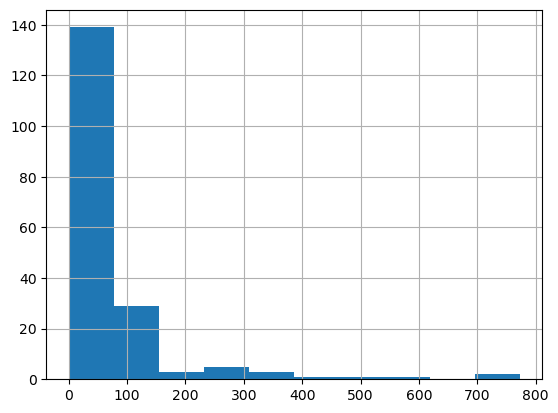

In [352]:
dbaasp['ic50_microg/ml'] = dbaasp.apply(lambda row: calc_ic50_adjusted(row['ic50'],
                                                                       row['units'],
                                                                       row['molwt']),
                                                                       axis=1)
dbaasp['ic50_microg/ml'].hist()

In [361]:
dbaasp_preprocessed = dbaasp.drop(columns=['target', 'mod', 'units', 'ic50'])
order  = ['id', 'db', 'seq', 'len', 'topology', 'stereo', 'nterm', 'cterm', 'cell_line', 'ss_bridge', 'smiles', 'molwt', 'ic50_microg/ml']
dbaasp_preprocessed = dbaasp_preprocessed[[*order]]
dbaasp_preprocessed.head()

,id,db,seq,len,topology,stereo,nterm,cterm,cell_line,ss_bridge,smiles,molwt,ic50_microg/ml
47,102,DBAASP,ALWKTLLKKVLKAAAKAALKAVLVGANA,28,Linear,L,Free,Free,Hep2,None,CC(C)C[C@H](NC(=O)[C@H](C)N)C(=O)N[C@@H](Cc1c[...,2861.610,75.71
47,102,DBAASP,ALWKTLLKKVLKAAAKAALKAVLVGANA,28,Linear,L,Free,Free,HeLa,None,CC(C)C[C@H](NC(=O)[C@H](C)N)C(=O)N[C@@H](Cc1c[...,2861.610,37.39
47,102,DBAASP,ALWKTLLKKVLKAAAKAALKAVLVGANA,28,Linear,L,Free,Free,HMC3,None,CC(C)C[C@H](NC(=O)[C@H](C)N)C(=O)N[C@@H](Cc1c[...,2861.610,20.89
90,146,DBAASP,KRIVQRIKDFLR,12,Linear,L,Free,Free,CEM-SS,None,CC[C@H](C)[C@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)[...,1571.941,63.50
103,160,DBAASP,VRRFPWWWPFLRR,13,Linear,L,Free,Free,MDA-MB-361,None,CC(C)C[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@@H]...,1902.294,142.00


In [362]:
dbaasp_preprocessed.to_csv('./preprocessed_datasets/dbaasp_regression.csv')

<h2>dbAMP3</h2>

<h3>Dataset</h3>

In [88]:
dbamp3 = pd.read_csv('dbamp3.csv').drop(columns=['Unnamed: 0', 'pdb', 'comments', 'mod'])
dbamp3_classic = dbamp3[(~dbamp3['seq'].str.contains('X')) & (~dbamp3['seq'].str.contains('x'))]
dbamp3_classic

,id,target,seq,topology,nterm,cterm,stereo,db,len
0,dbAMP_00091,Mycobacterium tuberculosis H37Rv (MIC50=0.5µM)...,ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,Linear,Free,Free,L,dbAMP3,53
1,dbAMP_00217,Aeromonas salmonicida 99-1 (MIC=32µg/ml)&&Aero...,AGWGSIFKHIFKAGKFIHGAIQAHND,Linear,Free,Free,L,dbAMP3,26
2,dbAMP_00235,Staphylococcus aureus NCTC 8325 (MIC=3.5µM)&&E...,AIGSILGALAKGLPTLISWIKNR,Linear,Free,Free,L,dbAMP3,23
3,dbAMP_00254,Escherichia coli ATCC 25922 (MIC=6.6µM)&&Staph...,AIPCGESCVWIPCISTVIGCSCSNKVCYR,Linear,Free,Free,L,dbAMP3,29
4,dbAMP_00283,Carnobacterium divergens DSM 20623 (MIC=0.625µ...,AISYGNGVYCNKEKCWVNKAENKQAITGIVIGGWASSLAGMGH,Linear,Free,Free,L,dbAMP3,43
...,...,...,...,...,...,...,...,...,...
1652,dbAMP_33439,Escherichia coli (IC50=125.08µg/ml)&&Escherich...,ALWMTLLKKVLKAAAKAALNAV,Linear,Free,Free,L,dbAMP3,22
1653,dbAMP_33440,Escherichia coli (IC50=104.62µg/ml)&&Escherich...,WMTLLKKVLKAAAKAALNAVLVGANA,Linear,Free,Free,L,dbAMP3,26
1654,dbAMP_33441,Escherichia coli (IC50=154.65µg/ml)&&Escherich...,LKKVLKAAAKAALNAVLVGANA,Linear,Free,Free,L,dbAMP3,22
1655,dbAMP_34575,Cancer cell lines: A549 (IC50 = 0.98 ± 0.11 μM...,IKLSKKTKKNLKKVLKGAIKGAIAVAKMV,Linear,Free,Free,L,dbAMP3,29


In [89]:
dbamp3_classic['target'].value_counts()

target
Escherichia coli DH5alpha (MIC=>64µM)&&Staphylococcus xylosus (MIC=>64µM)&&Human histiocytic lymphoma U-937 (LD50=>64µM)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [92]:
dbamp3_classic['target'] = dbamp3_classic['target'].apply(lambda x: x.split('&&'))
dbamp3_classic = dbamp3_classic.explode(column='target')
print(*list(dbamp3_classic['target']), sep='\n')


Mycobacterium tuberculosis H37Rv (MIC50=0.5µM)
Staphylococcus aureus MTCC 1430 (MIC50=4µM)
Bacillus subtilis MTCC 121 (MIC50=6µM)
Escherichia coli MTCC 1610 (MIC=100µM)
Mycobacterium smegmatis mc2-155 (MIC50=45µM)
Mycobacterium tuberculosis H37Rv (MIC=16µM)
Staphylococcus aureus MTCC 1430 (MBC=8µM)
Human breast adenocarcinoma MCF-7 (LC50=6µM)
Human fibrosarcoma HT1080 (LC50=7.5µM)
Human lung carcinoma H1299 (LC50=7µM)
Human cervical carcinoma HeLa (LC50=8µM)
Aeromonas salmonicida 99-1 (MIC=32µg/ml)
Aeromonas salmonicida 97-4 (MIC=16µg/ml)
Salmonella enterica serovar typhimurium MS7953s (MIC=16µg/ml)
Salmonella enterica subsp. enterica serovar Typhimurium ATCC 14028s (MIC=>64µg/ml)
Pseudomonas aeruginosa K799 (MIC=32µg/ml)
Pseudomonas aeruginosa Z61 (MIC=8µg/ml)
Escherichia coli CGSC 4908 (MIC=16µg/ml)
Escherichia coli UB1005 (MIC=16µg/ml)
Escherichia coli DC2 (MIC=16µg/ml)
Staphylococcus epidermidis C621 (MIC=16µg/ml)
Staphylococcus aureus C623 (MIC=16µg/ml)
Candida albicans C627 (MIC=

/tmp/ipykernel_863252/779909819.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbamp3_classic['target'] = dbamp3_classic['target'].apply(lambda x: x.split('&&'))


In [93]:
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['target'].str.contains('Escherichia coli'))]
dbamp3_classic

,id,target,seq,topology,nterm,cterm,stereo,db,len
0,dbAMP_00091,Mycobacterium tuberculosis H37Rv (MIC50=0.5µM),ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,Linear,Free,Free,L,dbAMP3,53
0,dbAMP_00091,Staphylococcus aureus MTCC 1430 (MIC50=4µM),ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,Linear,Free,Free,L,dbAMP3,53
0,dbAMP_00091,Bacillus subtilis MTCC 121 (MIC50=6µM),ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,Linear,Free,Free,L,dbAMP3,53
0,dbAMP_00091,Mycobacterium smegmatis mc2-155 (MIC50=45µM),ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,Linear,Free,Free,L,dbAMP3,53
0,dbAMP_00091,Mycobacterium tuberculosis H37Rv (MIC=16µM),ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,Linear,Free,Free,L,dbAMP3,53
...,...,...,...,...,...,...,...,...,...
1654,dbAMP_33441,Human colon adenocarcinoma SW620 (35.72±18.49%...,LKKVLKAAAKAALNAVLVGANA,Linear,Free,Free,L,dbAMP3,22
1655,dbAMP_34575,Cancer cell lines: A549 (IC50 = 0.98 ± 0.11 μM...,IKLSKKTKKNLKKVLKGAIKGAIAVAKMV,Linear,Free,Free,L,dbAMP3,29
1656,dbAMP_34594,Gram-positive bacteria:Bacillus megaterium(MIC...,GPKTKAACKMACKLATCGKKPGGWKCKLCELGCDAV,Linear,Free,Free,L,dbAMP3,36
1656,dbAMP_34594,Fungi: Rhodotorula sp(MIC=23.2 µg/mL);Aurobasi...,GPKTKAACKMACKLATCGKKPGGWKCKLCELGCDAV,Linear,Free,Free,L,dbAMP3,36


In [94]:
dbamp3_classic['target'] = dbamp3_classic['target'].apply(lambda x: x.split(':')[-1].strip())
dbamp3_classic

,id,target,seq,topology,nterm,cterm,stereo,db,len
0,dbAMP_00091,Mycobacterium tuberculosis H37Rv (MIC50=0.5µM),ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,Linear,Free,Free,L,dbAMP3,53
0,dbAMP_00091,Staphylococcus aureus MTCC 1430 (MIC50=4µM),ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,Linear,Free,Free,L,dbAMP3,53
0,dbAMP_00091,Bacillus subtilis MTCC 121 (MIC50=6µM),ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,Linear,Free,Free,L,dbAMP3,53
0,dbAMP_00091,Mycobacterium smegmatis mc2-155 (MIC50=45µM),ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,Linear,Free,Free,L,dbAMP3,53
0,dbAMP_00091,Mycobacterium tuberculosis H37Rv (MIC=16µM),ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,Linear,Free,Free,L,dbAMP3,53
...,...,...,...,...,...,...,...,...,...
1654,dbAMP_33441,Human colon adenocarcinoma SW620 (35.72±18.49%...,LKKVLKAAAKAALNAVLVGANA,Linear,Free,Free,L,dbAMP3,22
1655,dbAMP_34575,"A549 (IC50 = 0.98 ± 0.11 μM), HCT116 (IC50 = 1...",IKLSKKTKKNLKKVLKGAIKGAIAVAKMV,Linear,Free,Free,L,dbAMP3,29
1656,dbAMP_34594,Bacillus megaterium(MIC=0.5 µg/mL); Bacillus s...,GPKTKAACKMACKLATCGKKPGGWKCKLCELGCDAV,Linear,Free,Free,L,dbAMP3,36
1656,dbAMP_34594,Rhodotorula sp(MIC=23.2 µg/mL);Aurobasidium po...,GPKTKAACKMACKLATCGKKPGGWKCKLCELGCDAV,Linear,Free,Free,L,dbAMP3,36


In [95]:
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['target'].str.contains(';'))]
dbamp3_classic

,id,target,seq,topology,nterm,cterm,stereo,db,len
0,dbAMP_00091,Mycobacterium tuberculosis H37Rv (MIC50=0.5µM),ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,Linear,Free,Free,L,dbAMP3,53
0,dbAMP_00091,Staphylococcus aureus MTCC 1430 (MIC50=4µM),ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,Linear,Free,Free,L,dbAMP3,53
0,dbAMP_00091,Bacillus subtilis MTCC 121 (MIC50=6µM),ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,Linear,Free,Free,L,dbAMP3,53
0,dbAMP_00091,Mycobacterium smegmatis mc2-155 (MIC50=45µM),ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,Linear,Free,Free,L,dbAMP3,53
0,dbAMP_00091,Mycobacterium tuberculosis H37Rv (MIC=16µM),ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,Linear,Free,Free,L,dbAMP3,53
...,...,...,...,...,...,...,...,...,...
1654,dbAMP_33441,Corynebacterium striatum (IC50=118.7-290.8µg/ml),LKKVLKAAAKAALNAVLVGANA,Linear,Free,Free,L,dbAMP3,22
1654,dbAMP_33441,Corynebacterium striatum (MIC=289.35-790.8µg/ml),LKKVLKAAAKAALNAVLVGANA,Linear,Free,Free,L,dbAMP3,22
1654,dbAMP_33441,Human colon adenocarcinoma SW620 (35.72±18.49%...,LKKVLKAAAKAALNAVLVGANA,Linear,Free,Free,L,dbAMP3,22
1655,dbAMP_34575,"A549 (IC50 = 0.98 ± 0.11 μM), HCT116 (IC50 = 1...",IKLSKKTKKNLKKVLKGAIKGAIAVAKMV,Linear,Free,Free,L,dbAMP3,29


In [96]:
dbamp3_classic['target'] = dbamp3_classic['target'].apply(lambda x: x.split(','))
dbamp3_classic = dbamp3_classic.explode(column='target')
dbamp3_classic

/tmp/ipykernel_863252/4128308136.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbamp3_classic['target'] = dbamp3_classic['target'].apply(lambda x: x.split(','))


,id,target,seq,topology,nterm,cterm,stereo,db,len
0,dbAMP_00091,Mycobacterium tuberculosis H37Rv (MIC50=0.5µM),ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,Linear,Free,Free,L,dbAMP3,53
0,dbAMP_00091,Staphylococcus aureus MTCC 1430 (MIC50=4µM),ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,Linear,Free,Free,L,dbAMP3,53
0,dbAMP_00091,Bacillus subtilis MTCC 121 (MIC50=6µM),ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,Linear,Free,Free,L,dbAMP3,53
0,dbAMP_00091,Mycobacterium smegmatis mc2-155 (MIC50=45µM),ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,Linear,Free,Free,L,dbAMP3,53
0,dbAMP_00091,Mycobacterium tuberculosis H37Rv (MIC=16µM),ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,Linear,Free,Free,L,dbAMP3,53
...,...,...,...,...,...,...,...,...,...
1654,dbAMP_33441,Human colon adenocarcinoma SW620 (35.72±18.49%...,LKKVLKAAAKAALNAVLVGANA,Linear,Free,Free,L,dbAMP3,22
1655,dbAMP_34575,A549 (IC50 = 0.98 ± 0.11 μM),IKLSKKTKKNLKKVLKGAIKGAIAVAKMV,Linear,Free,Free,L,dbAMP3,29
1655,dbAMP_34575,HCT116 (IC50 = 1.841 ± 0.34 μM),IKLSKKTKKNLKKVLKGAIKGAIAVAKMV,Linear,Free,Free,L,dbAMP3,29
1655,dbAMP_34575,HepG2 (IC50 = 4.54 ± 0.25 μM),IKLSKKTKKNLKKVLKGAIKGAIAVAKMV,Linear,Free,Free,L,dbAMP3,29


In [97]:
dbamp3_classic['cell_line'] = dbamp3_classic['target'].apply(lambda x: x.split('(')[0].strip())
dbamp3_classic['cell_line'] = dbamp3_classic['cell_line'].apply(lambda x: x.split('[')[0].strip())
print(*dbamp3_classic['cell_line'].unique(), sep='\n')

Mycobacterium tuberculosis H37Rv
Staphylococcus aureus MTCC 1430
Bacillus subtilis MTCC 121
Mycobacterium smegmatis mc2-155
Human breast adenocarcinoma MCF-7
Human fibrosarcoma HT1080
Human lung carcinoma H1299
Human cervical carcinoma HeLa
Aeromonas salmonicida 99-1
Aeromonas salmonicida 97-4
Salmonella enterica serovar typhimurium MS7953s
Salmonella enterica subsp. enterica serovar Typhimurium ATCC 14028s
Pseudomonas aeruginosa K799
Pseudomonas aeruginosa Z61
Staphylococcus epidermidis C621
Staphylococcus aureus C623
Candida albicans C627
Human promyelocytic leukemia HL-60
Staphylococcus aureus NCTC 8325
Candida albicans ATCC 90028
Mouse T-lymphoma cells EL4
Klebsiella pneumoniae KK3 9904
Enterobacter cloacae HNTCC 53001
Pseudomonas aeruginosa ATCC 27853
Salmonella enterica subsp. enterica serovar Typhimurium LT2
Proteus mirabilis ATCC 25933
Staphylococcus epidermidis RP62A
Enterococcus faecalis ATCC 29212
Streptococcus group B HNTCC 80130
Staphylococcus aureus T7/5
Staphylococcus au

In [98]:
# clean up for non-mammalian cells
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('acter'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('coccus'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('monas'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('ella'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('brio'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('acillus'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('idium'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('irus'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('sp.'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('il'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('CoV'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('Listeria'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('Yersinia'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('Candida'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('Leishmania'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('pathway'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('Pichia'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('Proteus'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('Paracoccidioides'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('Alcaligenes'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('fibrinogen'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('Fusarium'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('HIV'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('Plasmodium'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('Rhizoctonia'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('Goffeauzyma'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('Puccinia'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('Batrachochytrium'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('HSV'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('plasma'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('nia '))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('ria '))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('Periplaneta'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('Serratia'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('Botrytis'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('Mannheimia'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('Rhizopus'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('Leuconostoc'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('Trypanosoma'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('Rothia'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('Haemonchus'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('Mycoplasmopsis'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('Coprinus'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('Providencia'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('Sporothrix'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('Nocardia'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('Yarrowia'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('Rhizopus'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('Pantoea'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('Cov'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('DENV'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('rich'))]
dbamp3_classic = dbamp3_classic[(~dbamp3_classic['cell_line'].str.contains('myces'))]




print(*dbamp3_classic['cell_line'].unique(), sep='\n')


Human breast adenocarcinoma MCF-7
Human fibrosarcoma HT1080
Human lung carcinoma H1299
Human cervical carcinoma HeLa
Human promyelocytic leukemia HL-60
Mouse T-lymphoma cells EL4
Human colon adenocarcinoma Caco-2
Human breast adenocarcinoma MDA-MB-231
Mouse skin melanoma B16-F10
Human squamous lung carcinoma NCI-H157
Human prostate adenocarcinoma PC-3
Human lung carcinoma A549
Human colon adenocarcinoma SW620
Human epidermoid cancer Hep2
Human neuroblastoma
Human hepatocellular carcinoma HepG2
Human lung adenocarcinoma NCI-H838
Human glioblastoma U251-MG
Human colon adenocarcinoma HCT 116
Human colon adenocarcinoma HCT-15
Human histiocytic lymphoma U-937/GTB
Mouse lymphocytic leukemia L1210
Human breast cancer
Human colon adenocarcinoma SW480
Human myelogenous leukemia K562
Human colon adenocarcinoma HT29
Human lung adenocarcinoma NCI-H23
Human gastric cancer NUGC-3
Human renal adenocarcinoma ACHN
Human melanoma BMKC
Human cervical carcinoma HeLa S3
Human acute monocytic leukemia THP-1

In [99]:
dbamp3_classic

,id,target,seq,topology,nterm,cterm,stereo,db,len,cell_line
0,dbAMP_00091,Human breast adenocarcinoma MCF-7 (LC50=6µM),ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,Linear,Free,Free,L,dbAMP3,53,Human breast adenocarcinoma MCF-7
0,dbAMP_00091,Human fibrosarcoma HT1080 (LC50=7.5µM),ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,Linear,Free,Free,L,dbAMP3,53,Human fibrosarcoma HT1080
0,dbAMP_00091,Human lung carcinoma H1299 (LC50=7µM),ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,Linear,Free,Free,L,dbAMP3,53,Human lung carcinoma H1299
0,dbAMP_00091,Human cervical carcinoma HeLa (LC50=8µM),ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,Linear,Free,Free,L,dbAMP3,53,Human cervical carcinoma HeLa
1,dbAMP_00217,Human promyelocytic leukemia HL-60 (50% Cell d...,AGWGSIFKHIFKAGKFIHGAIQAHND,Linear,Free,Free,L,dbAMP3,26,Human promyelocytic leukemia HL-60
...,...,...,...,...,...,...,...,...,...,...
1654,dbAMP_33441,Human colon adenocarcinoma SW620 (35.72±18.49%...,LKKVLKAAAKAALNAVLVGANA,Linear,Free,Free,L,dbAMP3,22,Human colon adenocarcinoma SW620
1655,dbAMP_34575,A549 (IC50 = 0.98 ± 0.11 μM),IKLSKKTKKNLKKVLKGAIKGAIAVAKMV,Linear,Free,Free,L,dbAMP3,29,A549
1655,dbAMP_34575,HCT116 (IC50 = 1.841 ± 0.34 μM),IKLSKKTKKNLKKVLKGAIKGAIAVAKMV,Linear,Free,Free,L,dbAMP3,29,HCT116
1655,dbAMP_34575,HepG2 (IC50 = 4.54 ± 0.25 μM),IKLSKKTKKNLKKVLKGAIKGAIAVAKMV,Linear,Free,Free,L,dbAMP3,29,HepG2


In [100]:
dbamp3_classic['cell_line'] = dbamp3_classic['cell_line'].apply(lambda x: x.split(' and '))
dbamp3_classic = dbamp3_classic.explode(column='cell_line')
dbamp3_classic

,id,target,seq,topology,nterm,cterm,stereo,db,len,cell_line
0,dbAMP_00091,Human breast adenocarcinoma MCF-7 (LC50=6µM),ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,Linear,Free,Free,L,dbAMP3,53,Human breast adenocarcinoma MCF-7
0,dbAMP_00091,Human fibrosarcoma HT1080 (LC50=7.5µM),ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,Linear,Free,Free,L,dbAMP3,53,Human fibrosarcoma HT1080
0,dbAMP_00091,Human lung carcinoma H1299 (LC50=7µM),ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,Linear,Free,Free,L,dbAMP3,53,Human lung carcinoma H1299
0,dbAMP_00091,Human cervical carcinoma HeLa (LC50=8µM),ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,Linear,Free,Free,L,dbAMP3,53,Human cervical carcinoma HeLa
1,dbAMP_00217,Human promyelocytic leukemia HL-60 (50% Cell d...,AGWGSIFKHIFKAGKFIHGAIQAHND,Linear,Free,Free,L,dbAMP3,26,Human promyelocytic leukemia HL-60
...,...,...,...,...,...,...,...,...,...,...
1654,dbAMP_33441,Human colon adenocarcinoma SW620 (35.72±18.49%...,LKKVLKAAAKAALNAVLVGANA,Linear,Free,Free,L,dbAMP3,22,Human colon adenocarcinoma SW620
1655,dbAMP_34575,A549 (IC50 = 0.98 ± 0.11 μM),IKLSKKTKKNLKKVLKGAIKGAIAVAKMV,Linear,Free,Free,L,dbAMP3,29,A549
1655,dbAMP_34575,HCT116 (IC50 = 1.841 ± 0.34 μM),IKLSKKTKKNLKKVLKGAIKGAIAVAKMV,Linear,Free,Free,L,dbAMP3,29,HCT116
1655,dbAMP_34575,HepG2 (IC50 = 4.54 ± 0.25 μM),IKLSKKTKKNLKKVLKGAIKGAIAVAKMV,Linear,Free,Free,L,dbAMP3,29,HepG2


In [101]:
def cell_line_replacement(s):
    # Hep 3B
    s = s.replace('HeLa S3', 'HeLa-S3').replace('Huh-7.5.1 cells','Huh-7.5.1').replace('Hep 3B', 'Hep-3B')
    s = s.replace('Jurkat cancer cells', 'Jurkat').replace('RAW 264.7', 'RAW-264.7').replace('SNU 601', 'SNU-601')
    s = s.replace('Jurkat T-cell leukemia', 'Jurkat').replace('MKN 45', 'MKN-45')
    return s

dbamp3_classic['cell_line'] = dbamp3_classic['cell_line'].apply(cell_line_replacement)

print(*dbamp3_classic['cell_line'].unique(), sep='\n')

Human breast adenocarcinoma MCF-7
Human fibrosarcoma HT1080
Human lung carcinoma H1299
Human cervical carcinoma HeLa
Human promyelocytic leukemia HL-60
Mouse T-lymphoma cells EL4
Human colon adenocarcinoma Caco-2
Human breast adenocarcinoma MDA-MB-231
Mouse skin melanoma B16-F10
Human squamous lung carcinoma NCI-H157
Human prostate adenocarcinoma PC-3
Human lung carcinoma A549
Human colon adenocarcinoma SW620
Human epidermoid cancer Hep2
Human neuroblastoma
Human hepatocellular carcinoma HepG2
Human lung adenocarcinoma NCI-H838
Human glioblastoma U251-MG
Human colon adenocarcinoma HCT 116
Human colon adenocarcinoma HCT-15
Human histiocytic lymphoma U-937/GTB
Mouse lymphocytic leukemia L1210
Human breast cancer
Human colon adenocarcinoma SW480
Human myelogenous leukemia K562
Human colon adenocarcinoma HT29
Human lung adenocarcinoma NCI-H23
Human gastric cancer NUGC-3
Human renal adenocarcinoma ACHN
Human melanoma BMKC
Human cervical carcinoma HeLa-S3
Human acute monocytic leukemia THP-1

In [102]:
dbamp3_classic['cell_line'] = dbamp3_classic['cell_line'].apply(lambda x: x.split()[-1] if x !='' else None)
print(*dbamp3_classic['cell_line'].unique(), sep='\n')

MCF-7
HT1080
H1299
HeLa
HL-60
EL4
Caco-2
MDA-MB-231
B16-F10
NCI-H157
PC-3
A549
SW620
Hep2
neuroblastoma
HepG2
NCI-H838
U251-MG
116
HCT-15
U-937/GTB
L1210
cancer
SW480
K562
HT29
NCI-H23
NUGC-3
ACHN
BMKC
HeLa-S3
THP-1
SiHa
B16
SMMC-7721
HSC-4
KBv
KB
NCI-H460
MDA-MB-435S
A375
U87-MG
LNCaP
Huh-7.5.1
4T1
Hep-3B
NCI-N87
DU145
BEL-7402
Bcap-37
LK-2
NCI-H446
BGC-823
HO-8910
A549/paclitaxel
U-937
Jurkat
E6-1
CCRF-CEM
RAW-264.7
SGC-7901
MGC-803
LoVo
Huh7
SK-HEP-1
C8166
Molt-4
BIU-87
T24
II
MM96L
HFF-1
RPMI-8226
RPMI-8226/Dox40
RPMI-8226/LR-5
U-937-Vcr
CCRF-CEM/VM-1
NCI-H69
NCI-H69AR
leukemia
carcinoma
melanoma
RAJI
A2058
YAC-1
K562/ADM
EJ
U373-MG
RBL-2H3
MCF-7/ADM
None
ME-180
MONO-MAC-6
M1
SK-BR-3
NCI-H146
NCI-H128
MDA-MB-361
HeLa-ACE2
HepG2.2.15
A431
Tumor
Cancer
SW1116
AML-2
SNU-601
MDA-MB-435
SF-268
SK-MEL-2
UACC-62
A498
IGROV1
SK-OV-3
CaSki
CAPAN-1
MCA205
109
HRT-18G
HCT-8
C1498
Kasumi-1
TZM-bl
MT-4
A2780
A2780CisR
Panc-1
PC-12
Vero
AGS
rhabdomyosarcoma
CRL-1739
LA-N-1
SH-SY5Y
J5
DLD-1
MEC-1

In [103]:
dbamp3_classic = dbamp3_classic.dropna(subset=['cell_line'])
dbamp3_classic.shape

(3680, 10)

In [104]:
print(*dbamp3_classic['target'].unique(), sep='\n')

Human breast adenocarcinoma MCF-7 (LC50=6µM)
Human fibrosarcoma HT1080 (LC50=7.5µM)
Human lung carcinoma H1299 (LC50=7µM)
Human cervical carcinoma HeLa (LC50=8µM)
Human promyelocytic leukemia HL-60 (50% Cell death=8µg/ml)
Mouse T-lymphoma cells EL4 (LC50=14µM)
Human cervical carcinoma HeLa (IC50=1.0µM)
Human colon adenocarcinoma Caco-2 (10% Killing=100µg/ml)
Human breast adenocarcinoma MDA-MB-231 (50% Cell death=12.5µg/ml)
Mouse skin melanoma B16-F10 (IC50=8.69µM)
Human squamous lung carcinoma NCI-H157 (IC50=15.67µM)
Human prostate adenocarcinoma PC-3 (IC50=18.20µM)
Human breast adenocarcinoma MCF-7 (IC50=15µM)
Human breast adenocarcinoma MCF-7 (IC50=12µM)
Human lung carcinoma A549 (30% Cytotoxicity=40µM)
Human cervical carcinoma HeLa (50% Cytotoxicity=28.11µg/ml)
Human colon adenocarcinoma SW620 (44.76±23.77% Cytotoxicity=256µg/ml)
Human epidermoid cancer Hep2 (50% Cytotoxicity=16.51µg/ml)
Human neuroblastoma (IC50=1.5µM)
Human neuroblastoma (IC50=7.5µM)
Human hepatocellular carcinoma

In [105]:
def get_ic50str(s):
    if s.find('(') != -1:
        ans = s.split('(')[-1]
        ans = ans.replace(').', ')')
        return ans[:-1]
    elif s.find('[') !=-1:
        ans = s.split('[')[-1]
        return ans[:-1]
    else:
        return None
    
dbamp3_classic['ic50'] = dbamp3_classic['target'].apply(get_ic50str)
dbamp3_classic = dbamp3_classic.dropna(subset=['ic50'])
dbamp3_classic.shape

/tmp/ipykernel_863252/4218951459.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbamp3_classic['ic50'] = dbamp3_classic['target'].apply(get_ic50str)


(3650, 11)

In [106]:
def check_measurement(s):
    measures = ('LC50', 'LD50', 'IC50', 'EC50', 'ED50', '50%')
    for m in measures:
        if s.find(m) !=-1:
            return s
        
    return None

dbamp3_classic['ic50'] = dbamp3_classic['ic50'].apply(check_measurement)
dbamp3_classic = dbamp3_classic.dropna(subset=['ic50'])
dbamp3_classic.shape

(3071, 11)

In [107]:
print(*dbamp3_classic['ic50'].unique(), sep='\n')

LC50=6µM
LC50=7.5µM
LC50=7µM
LC50=8µM
50% Cell death=8µg/ml
LC50=14µM
IC50=1.0µM
50% Cell death=12.5µg/ml
IC50=8.69µM
IC50=15.67µM
IC50=18.20µM
IC50=15µM
IC50=12µM
50% Cytotoxicity=28.11µg/ml
50% Cytotoxicity=16.51µg/ml
IC50=1.5µM
IC50=7.5µM
50% Cytotoxicity=60.43µM
IC50=1500µM
IC50=1000µM
IC50=6.56µM
IC50=>100µM
IC50=8.33µM
LC50=<5µg/ml
IC50=0.22µM
IC50=0.1µM
IC50=40µM
IC50=46µM
IC50=11.2µg/ml
IC50=23.2µg/ml
IC50=11.7µg/ml
IC50=10.9µg/ml
IC50=10.5µg/ml
IC50=12.3µg/ml
LD50=23µg/ml
LD50=46µg/ml
LD50=128µg/ml
LD50=140µg/ml
LD50=50µg/ml
LD50=44µg/ml
IC50=>200µM
IC50=45-50µM
50% Cytotoxicity=73µM
50% Cell death=>128µg/ml
IC50=118µM
IC50=30µM
IC50=12.5µM
IC50=17.26µM
LC50=60±0µM
LC50=57±3µM
IC50=20.1µg/ml
IC50=2.75µM
IC50=2.94µM
IC50=3.33µM
IC50=2.07µM
IC50=3.60µM
IC50=3.51µM
IC50=2.93µM
IC50=7.222µM
IC50=9.478µM
IC50=10.21Unknown Unit
IC50=28.00µM
IC50=25.58µM
IC50=29.23µM
LC50=4µM
50% Cell death=128µg/ml
50% Cell death=>500µg/ml
50% Cell death=79.8µg/ml
IC50=13.4µg/ml
50% Cell death=32µg/

In [108]:
#µ - most popular
#μM - 4 entries
def get_units2(s):
    if s.find('µg/ml')!=-1:
        return 'µg/ml'
    if (s.find('μM') !=-1) or (s.find('µM')!=-1) or (s.find('microM')!=-1) :
        return 'microM'
    
    
    return None


dbamp3_classic['units'] = dbamp3_classic['ic50'].apply(get_units2)
dbamp3_classic['units'].value_counts()

dbamp3_classic = dbamp3_classic.dropna(subset=['units'])
dbamp3_classic.shape


(3052, 12)

In [109]:
dbamp3_classic['ic50'].value_counts()

ic50
IC50=>100µM            87
LD50=>1000µg/ml        81
LD50=>64µM             42
IC50=>200µM            36
IC50=>10µg/ml          36
                       ..
IC50=93.80 ± 2.17µM     1
IC50=20.94 ± 5.18µM     1
IC50=766.9µM            1
IC50=13.57µM            1
IC50=31.8±1.9µM         1
Name: count, Length: 1912, dtype: int64

In [110]:
dbamp3_classic['ic50'] = dbamp3_classic['ic50'].apply(lambda x: x.split('=')[-1])
dbamp3_classic['ic50'].value_counts()

ic50
>100µM        127
>1000µg/ml     81
>64µM          58
>200µM         43
10µM           39
             ... 
0.9±0.3µM       1
16.51µg/ml      1
28.11µg/ml      1
15.67µM         1
8.69µM          1
Name: count, Length: 1753, dtype: int64

In [111]:

dbamp3_classic['ic50'] =dbamp3_classic['ic50'].apply(lambda x: x.split('±')[0])
dbamp3_classic['ic50'] =dbamp3_classic['ic50'].apply(lambda x: x.split('-')[0])
dbamp3_classic['ic50'] =dbamp3_classic['ic50'].apply(lambda x: x.split('+')[0])
dbamp3_classic['ic50'] =dbamp3_classic['ic50'].apply(lambda x: x.replace('<','').replace('>', '').replace('µg/ml', '').replace('μM', '').replace('µM','').replace('microM','').strip())
dbamp3_classic['ic50'].value_counts()

ic50
100      171
10        95
1000      87
64        68
50        58
        ... 
208        1
11.71      1
9.164      1
2.865      1
2.86       1
Name: count, Length: 1178, dtype: int64

<Axes: >

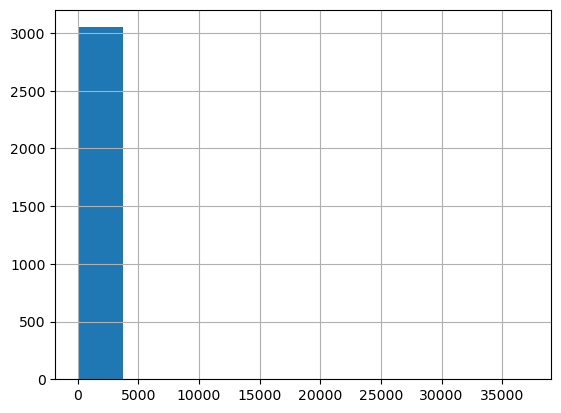

In [112]:
dbamp3_classic['ic50'] = dbamp3_classic['ic50'].apply(float)
dbamp3_classic['ic50'].hist()

In [123]:
dbamp3_classic['units'].value_counts()

units
microM    2301
µg/ml      751
Name: count, dtype: int64

<h3>SMILES</h3>

In [120]:
dbamp3_classic['ss_bridge'] = None

In [121]:
dbamp3_classic['smiles'] = dbamp3_classic.apply(lambda row: calc_smiles_classic(row['seq'],
                                                                                row['nterm'],
                                                                                row['cterm'],
                                                                                row['topology'],
                                                                                row['ss_bridge']), axis=1)
dbamp3_classic

,id,target,seq,topology,nterm,cterm,stereo,db,len,cell_line,ic50,units,ss_bridge,smiles
0,dbAMP_00091,Human breast adenocarcinoma MCF-7 (LC50=6µM),ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,Linear,Free,Free,L,dbAMP3,53,MCF-7,6.000,microM,None,CC[C@H](C)[C@H](NC(=O)[C@H](C)NC(=O)[C@H](CC(=...
0,dbAMP_00091,Human fibrosarcoma HT1080 (LC50=7.5µM),ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,Linear,Free,Free,L,dbAMP3,53,HT1080,7.500,microM,None,CC[C@H](C)[C@H](NC(=O)[C@H](C)NC(=O)[C@H](CC(=...
0,dbAMP_00091,Human lung carcinoma H1299 (LC50=7µM),ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,Linear,Free,Free,L,dbAMP3,53,H1299,7.000,microM,None,CC[C@H](C)[C@H](NC(=O)[C@H](C)NC(=O)[C@H](CC(=...
0,dbAMP_00091,Human cervical carcinoma HeLa (LC50=8µM),ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,Linear,Free,Free,L,dbAMP3,53,HeLa,8.000,microM,None,CC[C@H](C)[C@H](NC(=O)[C@H](C)NC(=O)[C@H](CC(=...
1,dbAMP_00217,Human promyelocytic leukemia HL-60 (50% Cell d...,AGWGSIFKHIFKAGKFIHGAIQAHND,Linear,Free,Free,L,dbAMP3,26,HL-60,8.000,µg/ml,None,CC[C@H](C)[C@H](NC(=O)[C@H](C)NC(=O)CNC(=O)[C@...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1646,dbAMP_32874,Human hepatocellular carcinoma HepG2 (IC50=7.5...,FKIGGFIKKLWRSLLA,Linear,Free,Free,L,dbAMP3,16,HepG2,7.500,microM,None,CC[C@H](C)[C@H](NC(=O)[C@H](CCCCN)NC(=O)[C@@H]...
1655,dbAMP_34575,A549 (IC50 = 0.98 ± 0.11 μM),IKLSKKTKKNLKKVLKGAIKGAIAVAKMV,Linear,Free,Free,L,dbAMP3,29,A549,0.980,microM,None,CC[C@H](C)[C@H](N)C(=O)N[C@@H](CCCCN)C(=O)N[C@...
1655,dbAMP_34575,HCT116 (IC50 = 1.841 ± 0.34 μM),IKLSKKTKKNLKKVLKGAIKGAIAVAKMV,Linear,Free,Free,L,dbAMP3,29,HCT116,1.841,microM,None,CC[C@H](C)[C@H](N)C(=O)N[C@@H](CCCCN)C(=O)N[C@...
1655,dbAMP_34575,HepG2 (IC50 = 4.54 ± 0.25 μM),IKLSKKTKKNLKKVLKGAIKGAIAVAKMV,Linear,Free,Free,L,dbAMP3,29,HepG2,4.540,microM,None,CC[C@H](C)[C@H](N)C(=O)N[C@@H](CCCCN)C(=O)N[C@...


In [122]:
def calc_wt_from_smiles(sm):
    mol = Chem.MolFromSmiles(sm)
    molecular_mass = Descriptors.MolWt(mol)
    return molecular_mass

dbamp3_classic['molwt'] = dbamp3_classic['smiles'].apply(calc_wt_from_smiles)
dbamp3_classic['molwt'].value_counts()


molwt
1456.929    30
2560.199    25
2907.506    25
1414.848    23
2902.363    22
            ..
1458.816     1
2113.420     1
2259.746     1
3817.674     1
4215.207     1
Name: count, Length: 1089, dtype: int64

<Axes: >

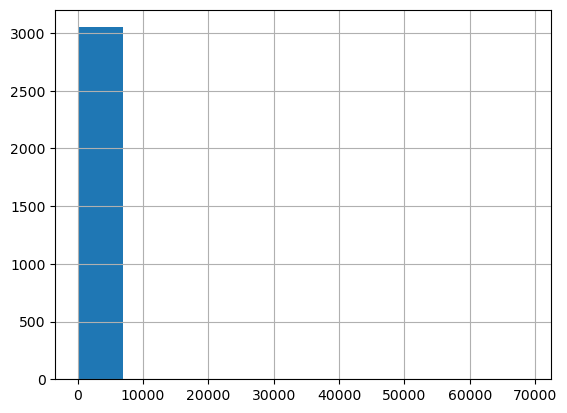

In [125]:
dbamp3_classic['ic50_microg/ml'] = dbamp3_classic.apply(lambda row: calc_ic50_adjusted(row['ic50'],
                                                                                       row['units'],
                                                                                       row['molwt']),
                                                                                       axis=1)
dbamp3_classic['ic50_microg/ml'].hist()

In [127]:
dbamp3_classic.columns

Index(['id', 'target', 'seq', 'topology', 'nterm', 'cterm', 'stereo', 'db',
       'len', 'cell_line', 'ic50', 'units', 'ss_bridge', 'smiles', 'molwt',
       'ic50_microg/ml'],
      dtype='object')

In [130]:
dbamp3_classic = dbamp3_classic.drop(columns=['target', 'units', 'ic50'])
order  = ['id', 'db', 'seq', 'len', 'topology', 'stereo', 'nterm', 'cterm', 'cell_line', 'ss_bridge', 'smiles', 'molwt', 'ic50_microg/ml']
dbamp3_classic = dbamp3_classic[[*order]]
dbamp3_classic.head()

,id,db,seq,len,topology,stereo,nterm,cterm,cell_line,ss_bridge,smiles,molwt,ic50_microg/ml
0,dbAMP_00091,dbAMP3,ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,53,Linear,L,Free,Free,MCF-7,None,CC[C@H](C)[C@H](NC(=O)[C@H](C)NC(=O)[C@H](CC(=...,6068.090,36.408540
0,dbAMP_00091,dbAMP3,ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,53,Linear,L,Free,Free,HT1080,None,CC[C@H](C)[C@H](NC(=O)[C@H](C)NC(=O)[C@H](CC(=...,6068.090,45.510675
0,dbAMP_00091,dbAMP3,ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,53,Linear,L,Free,Free,H1299,None,CC[C@H](C)[C@H](NC(=O)[C@H](C)NC(=O)[C@H](CC(=...,6068.090,42.476630
0,dbAMP_00091,dbAMP3,ACVNQCPDAIDRFIVKDKGCHGVEKKYYKQVYVACMNGQHLYCRTE...,53,Linear,L,Free,Free,HeLa,None,CC[C@H](C)[C@H](NC(=O)[C@H](C)NC(=O)[C@H](CC(=...,6068.090,48.544720
1,dbAMP_00217,dbAMP3,AGWGSIFKHIFKAGKFIHGAIQAHND,26,Linear,L,Free,Free,HL-60,None,CC[C@H](C)[C@H](NC(=O)[C@H](C)NC(=O)CNC(=O)[C@...,2851.276,8.000000


In [131]:
dbamp3_classic.to_csv('./preprocessed_datasets/dbamp3_regression.csv')

<h3>DRAMP</h3>

In [121]:
dramp = pd.read_csv('dramp.csv', index_col='Unnamed: 0').drop(columns=['pdb', 'comments'])
dramp.head()

,id,seq,len,target,topology,nterm,cterm,mod,stereo,db
51,DRAMP00795,GIPCGESCVFIPCITAAIGCSCKSKVCYRN,30,[Ref.21596752]Gram-positive bacteria: Staphylo...,Cyclic,Free,Free,There are three disulfide bonds between Cys4 a...,L,DRAMP
52,DRAMP00798,GIPCGESCVFIPCITGAIGCSCKSKVCYRN,30,[Ref.21596752]Gram-positive bacteria: Staphylo...,Cyclic,Free,Free,There are three disulfide bonds between Cys4 a...,L,DRAMP
67,DRAMP01064,AWKLFDDGV,9,[Ref.21882228]Gram-positive bacteria: Staphylo...,Linear,Free,Free,NaN,L,DRAMP
171,DRAMP03024,LKLKSIVSWAKKVL,14,[Ref.10667861] Gram-positive bacteria: Staphyl...,Linear,Free,Amidation,Free,L,DRAMP
327,DRAMP01607,GLFDIIKKIAESF,13,Gram-positive bacteria: Bacillus cereus (MIC=1...,Linear,Free,Amidation,Free,L,DRAMP


In [122]:
dramp['mod'] = dramp['mod'].fillna('Free')
dramp_classic = dramp[dramp['mod'] == 'Free']
dramp_classic.shape

(2988, 10)

In [123]:
target_list = list(dramp_classic['target'])
print(*target_list, sep='\n')

[Ref.21882228]Gram-positive bacteria: Staphylococcus epidermidis (MIC=60 µM), Bacillus subtilis (MIC=30 µM);##Gram-negative bacteria: Pseudomonas aeruginosa (MIC=30 µM), EEscherichia coli strain ATCC 8739 (MIC=30 µM).
[Ref.10667861] Gram-positive bacteria: Staphylococcus epidermidis ATTC 12228 (MIC=25 µM), Bacillus subtilis PCI 219 (MIC=25 µM), Enterococcus faecium EFMY-28 (MIC=12.5 µM);##Gram-negative bacterium: Escherichia coli NIHJ JC-2 (MIC=50 µM)
Gram-positive bacteria: Bacillus cereus (MIC=100 μg/ml), Leuconostoc lactis (MIC=12 μg/ml), Listeria innocua (MIC=100 μg/ml), Micrococcus luteus (MIC=100 μg/ml), Staphylococcus epidermidis (MIC=50 μg/ml), Streptococcus uberis (MIC=50 μg/ml), Staphylococcus aureus (MIC=8 μmol/L);##Gram-negative bacteria: Pasteurella multocida (MIC=100 μg/ml), Escherichia coli (MIC=8 μmol/L);##Fungi: Candida albicans (MIC=32 μmol/L)
Gram-positive bacteria: Bacillus cereus (MIC=50 μg/ml), Leuconostoc lactis (MIC=6 μg/ml), Listeria innocua (MIC=6 μg/ml), Micr

In [124]:
def parse_target(target_line):

    if target_line == 'Not available':
        return [None]
    
    if type(target_line) != str:
        return [None]

    # Tumor cells: mode
    if target_line[:12] == 'Tumor cells:':
        target_line = target_line[12:].strip()
        return target_line.split(';')
    

    # Cancer cell lines: mode
    if target_line.find('Cancer cell lines:') !=-1:
        border = target_line.find('Cancer cell lines:')+18
        target_line = target_line[border:].strip()
        return target_line.split(',')
    
    # Cancer:
    if target_line.find('Cancer cell lines:') !=-1:
        border = target_line.find('Cancer:')+7
        target_line = target_line[border:].strip()
        target_line = target_line.split('##')[0]
        return target_line.split(';')

    return [None]

In [125]:
dramp_classic['target'] = dramp_classic['target'].apply(parse_target)
dramp_classic['target']

/tmp/ipykernel_2898/2222884105.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dramp_classic['target'] = dramp_classic['target'].apply(parse_target)


67                                                [None]
171                                               [None]
327                                               [None]
328                                               [None]
329                                               [None]
                              ...                       
11607                               [C26 (IC50=10µg/mL)]
11608                               [C26 (IC50=25µg/mL)]
11609                               [C26 (IC50=14µg/mL)]
11610                               [C26 (IC50=22µg/mL)]
11611    [MCF-7  (IC50=29.06μM),  MCF-7  (IC50=35.34μM)]
Name: target, Length: 2988, dtype: object

In [126]:
dramp_classic = dramp_classic.explode('target').dropna(subset=['target'])
dramp_classic['target'].unique()

array(['A549 (IC50 = 15.22 ± 0.21 μM)',
       ' HCT116 (IC50 = 12.76 ± 0.43 μM)',
       ' HepG2 (IC50 = 8.07 ± 0.21 μM)', ..., 'C26 (IC50=44µg/mL)',
       'MCF-7  (IC50=29.06μM)', ' MCF-7  (IC50=35.34μM)'],
      shape=(2404,), dtype=object)

In [127]:
dramp_classic['target'] = dramp_classic['target'].apply(lambda x: x.replace('Leukemia cell lines', ''))
dramp_classic['target'] = dramp_classic['target'].apply(lambda x: x.replace('(NCI)', '[NCI]'))
dramp_classic['target'] = dramp_classic['target'].apply(lambda x: x.replace('(Bc1-xL dependent)', '[Bc1-xL dependent]'))
dramp_classic['target'] = dramp_classic['target'].apply(lambda x: x.replace('(Bcl-2 dependent)', '[Bcl-2 dependent]'))
dramp_classic['target'] = dramp_classic['target'].apply(lambda x: x.strip())

In [128]:
target_list = list(dramp_classic['target'])
print(*target_list, sep='\n')

A549 (IC50 = 15.22 ± 0.21 μM)
HCT116 (IC50 = 12.76 ± 0.43 μM)
HepG2 (IC50 = 8.07 ± 0.21 μM)
K562 (IC50=349.5μM)
U937 (IC50=303.2μM)
THP-1 (IC50=228.5μM)
K562 (IC50=184.9μM)
U937 (IC50=223.9μM)
THP-1 (IC50=196.1μM)
C4-2B (IC50 = 29.05 μM)
A549 (IC50 = 14.97 μM)
U87 (IC50 = 14.8 μM)
MCF-7 (14.16 μM)
A549 (IC50 = 0.98 ± 0.11 μM)
HCT116 (IC50 = 1.841 ± 0.34 μM)
HepG2 (IC50 = 4.54 ± 0.25 μM)
A549 (IC50 = 2.35 ± 0.31 μM)
HCT116 (IC50 = 8.09 ± 0.40 μM)
HepG2 (IC50 = 4.28 ± 0.38 μM)
A549 (IC50 = 1.82 ± 0.23 μM)
HCT116 (IC50 = 6.50 ± 0.32 μM)
HepG2 (IC50 = 4.96 ± 0.43 μM).
A549 (IC50 = 1.17 ± 0.23 μM)
HCT116 (IC50 = 4.93 ± 0.51 μM)
HepG2 (IC50 = 2.46 ± 0.32 μM).
Jurkat (IC50=75 µM)
A549 (IC50>100 µM)
K562 (IC50>100 µM)
MDA-MB-361 (IC50>100 µM)
K562 (IC50=3.5 µM)
Jurkat (IC50=4 µM)
MDA-MB-361 (IC50=8 µM)
Meth A (IC50=144 µM)
MT-1 (IC50>254 µM)
HT-29 (IC50>440 µM)
HT-29 (IC50=141 µM)
MT-1 (IC50=18 µM)
Meth A (IC50=32 µM)
MT-1 (IC50=16 µM)
Meth A (IC50=31 µM)
HT-29 (IC50=57 µM)
HT-29 (IC50=14 µM)


In [129]:
def parse_ic50(text):

    match = re.search(r'\((.*)\)', text)
    if match:
        return match.group(1)
    
    return None

dramp_classic['ic50'] = dramp_classic['target'].apply(parse_ic50)


In [130]:
print(*list(dramp_classic['ic50'].unique()), sep='\n')

IC50 = 15.22 ± 0.21 μM
IC50 = 12.76 ± 0.43 μM
IC50 = 8.07 ± 0.21 μM
IC50=349.5μM
IC50=303.2μM
IC50=228.5μM
IC50=184.9μM
IC50=223.9μM
IC50=196.1μM
IC50 = 29.05 μM
IC50 = 14.97 μM
IC50 = 14.8 μM
14.16 μM
IC50 = 0.98 ± 0.11 μM
IC50 = 1.841 ± 0.34 μM
IC50 = 4.54 ± 0.25 μM
IC50 = 2.35 ± 0.31 μM
IC50 = 8.09 ± 0.40 μM
IC50 = 4.28 ± 0.38 μM
IC50 = 1.82 ± 0.23 μM
IC50 = 6.50 ± 0.32 μM
IC50 = 4.96 ± 0.43 μM
IC50 = 1.17 ± 0.23 μM
IC50 = 4.93 ± 0.51 μM
IC50 = 2.46 ± 0.32 μM
IC50=75 µM
IC50>100 µM
IC50=3.5 µM
IC50=4 µM
IC50=8 µM
IC50=144 µM
IC50>254 µM
IC50>440 µM
IC50=141 µM
IC50=18 µM
IC50=32 µM
IC50=16 µM
IC50=31 µM
IC50=57 µM
IC50=14 µM
IC50=3 ± 1 μM(pH=7.4
pH=5.5)
IC50=6.6 µM
IC50=11 µM
IC50=12 µM
IC50=15 µM
IC50=110 µM
IC50=180 µM
IC50=87 µM
IC50=35 µM
IC50=52 µM
IC50=20 µM
IC50=24 µM
IC50=116 µM
IC50=248 µM
IC50=10 µM
IC50=25 µM
IC50=7.9 µM
IC50=29 µM
IC50=125 µM
IC50=423 µM
IC50=178 µM
IC50=92 µM
30-40% viablity=100 µM 
80-90% viablity=100 µM 
IC50=10 μM
IC50=1 μM
IC50>100 μM
IC50>10 μM
IC5

In [131]:
dramp_classic.shape

(3281, 11)

In [132]:
def clean_ic50(s):

    if s is None:
        return None

    whitelist = ('IC50', 'LC50', 'LD50', 'CC50', 'EC50', '50%')
    
    for w in whitelist:
        if s.find(w) !=-1:
            return s
        
    return None

dramp_classic['ic50'] = dramp_classic['ic50'].apply(clean_ic50)
dramp_classic = dramp_classic.dropna(subset=['ic50'])
dramp_classic.shape

(2710, 11)

In [133]:
dramp_classic['cell_line'] = dramp_classic['target'].apply(lambda x: x.split('(')[0].strip())
dramp_classic['cell_line'].value_counts()

cell_line
MCF-7                    277
A549                     240
HeLa                     228
K562                     153
HepG2                     94
                        ... 
Clinical isolate 22B       1
MCA 205                    1
Clinical isolate 4129      1
H460                       1
MDA361                     1
Name: count, Length: 189, dtype: int64

In [134]:
print(*list(dramp_classic['cell_line']), sep='\n')

A549
HCT116
HepG2
K562
U937
THP-1
K562
U937
THP-1
C4-2B
A549
U87
A549
HCT116
HepG2
A549
HCT116
HepG2
A549
HCT116
HepG2
A549
HCT116
HepG2
Jurkat
A549
K562
MDA-MB-361
K562
Jurkat
MDA-MB-361
Meth A
MT-1
HT-29
HT-29
MT-1
Meth A
MT-1
Meth A
HT-29
HT-29
A549
Meth A
MT-1
Meth A
MT-1
HT-29
MT-1
HT-29
Meth A
Meth A
HT-29
MT-1
MT-1
Meth A
HT-29
MT-1
Meth A
HT-29
Meth A
HT-29
MT-1
MT-1
HT-29
Meth A
MT-1
Meth A
HT-29
Meth A
MT-1
HT-29
HT-29
Meth A
MT-1
Breast cancer group [NCI]
CNS cancer group [NCI]
Colon cancer group [NCI]
Leukemia group [NCI]
Lung cancer group [NCI]
Melanoma cancer group [NCI]
Ovarian cancer group [NCI]
Prostate cancer group [NCI]
Renal cancer group [NCI]
Lung cancer group [NCI]
Breast cancer group [NCI]
CNS cancer group [NCI]
Colon cancer group [NCI]
Melanoma cancer group [NCI]
Ovarian cancer group [NCI]
Prostate cancer group [NCI]
Renal cancer group [NCI]
Leukemia group [NCI]
Breast cancer group [NCI]
CNS cancer group [NCI]
Colon cancer group [NCI]
Leukemia group [NCI]
Lung c

In [135]:
dramp_classic['cell_line'] = dramp_classic['cell_line'].apply(lambda x: x.split('/')[0])
dramp_classic['cell_line'].value_counts()

cell_line
MCF-7                    380
K562                     246
A549                     240
HeLa                     228
HepG2                     94
                        ... 
Clinical isolate 22B       1
MCA 205                    1
Clinical isolate 4129      1
H460                       1
MDA361                     1
Name: count, Length: 182, dtype: int64

In [136]:
dramp_classic.shape

(2710, 12)

In [137]:
def get_units(s):

    # μmol/mL
    for u in ('μmol/mL', 'µmol/mL', 'μmol/ml', 'µmol/ml'):
        if s.find(u) !=-1:
            return 'microM/ml'

    # microM [μ,µ]
    for u in ('μM', 'µM', 'μmol/L', 'µmol/L','μm', 'µm'):
        if s.find(u) !=-1:
            return 'microM'
        
    # microg/ml [μ,µ]
    for u in ('μg/ml', 'µg/ml', 'μg/mL', 'µg/mL', 'µg/m'):
        if s.find(u) !=-1:
            return 'microg/ml'
        
    # nM
    for u in ('nM'):
        if s.find(u) !=-1:
            return 'nanoM'
        
    
    # mg/mL
    for u in ('mg/ml', 'mg/mL'):
        if s.find(u) !=-1:
            return 'mg/ml'
        
    return s

dramp_classic['units'] = dramp_classic['target'].apply(get_units)
dramp_classic['units'].value_counts()


units
microM       2224
microg/ml     425
nanoM          46
mg/ml          13
microM/ml       2
Name: count, dtype: int64

In [ ]:
dramp_classic['ic50'] = dramp_classic['ic50'].apply(lambda x: x.replace('>', '=').replace('<', '=').replace('==', '='))
dramp_classic['ic50'] = dramp_classic['ic50'].apply(lambda x: x.split('±')[0])



In [139]:
print(*list(dramp_classic['ic50'].unique()), sep='\n')

IC50 = 15.22 
IC50 = 12.76 
IC50 = 8.07 
IC50=349.5μM
IC50=303.2μM
IC50=228.5μM
IC50=184.9μM
IC50=223.9μM
IC50=196.1μM
IC50 = 29.05 μM
IC50 = 14.97 μM
IC50 = 14.8 μM
IC50 = 0.98 
IC50 = 1.841 
IC50 = 4.54 
IC50 = 2.35 
IC50 = 8.09 
IC50 = 4.28 
IC50 = 1.82 
IC50 = 6.50 
IC50 = 4.96 
IC50 = 1.17 
IC50 = 4.93 
IC50 = 2.46 
IC50=75 µM
IC50=100 µM
IC50=3.5 µM
IC50=4 µM
IC50=8 µM
IC50=144 µM
IC50=254 µM
IC50=440 µM
IC50=141 µM
IC50=18 µM
IC50=32 µM
IC50=16 µM
IC50=31 µM
IC50=57 µM
IC50=14 µM
IC50=3 
IC50=6.6 µM
IC50=11 µM
IC50=12 µM
IC50=15 µM
IC50=110 µM
IC50=180 µM
IC50=87 µM
IC50=35 µM
IC50=52 µM
IC50=20 µM
IC50=24 µM
IC50=116 µM
IC50=248 µM
IC50=10 µM
IC50=25 µM
IC50=7.9 µM
IC50=29 µM
IC50=125 µM
IC50=423 µM
IC50=178 µM
IC50=92 µM
IC50=10 μM
IC50=1 μM
IC50=100 μM
IC50=10.4 µM
IC50=11.7 µM
IC50=16 µg/ml
IC50=18 µg/ml
IC50=20 µg/ml
IC50=23 µg/ml
IC50=30 µg/ml
IC50=34 µg/ml
IC50=40 µg/ml
IC50=45 µg/ml
IC50=49 µg/ml
IC50=53 µg/ml
IC50=6.23 µM
IC50=6.56 µM
IC50=7.28 µM
IC50=9.7 µM
IC50=100 µ

In [140]:
def clean_ic50_2(s):

    
    # μmol/mL
    for u in ('μmol/mL', 'µmol/mL', 'μmol/ml', 'µmol/ml'):
        if s.find(u) !=-1:
            return s.replace(u, '')

    # microM [μ,µ]
    for u in ('μM', 'µM', 'μmol/L', 'µmol/L','μm', 'µm'):
        if s.find(u) !=-1:
            return s.replace(u, '')
        
    # microg/ml [μ,µ]
    for u in ('μg/ml', 'µg/ml', 'μg/mL', 'µg/mL', 'µg/m'):
        if s.find(u) !=-1:
            return s.replace(u, '')
        
    # nM
    for u in ('nM'):
        if s.find(u) !=-1:
            return s.replace(u, '')
        
    
    # mg/mL
    for u in ('mg/ml', 'mg/mL'):
        if s.find(u) !=-1:
            return s.replace(u, '')
        
    return s
    

dramp_classic['ic50'] = dramp_classic['ic50'].apply(clean_ic50_2)
dramp_classic['ic50'] = dramp_classic['ic50'].apply(lambda x: x.replace(' at ', '='))
dramp_classic['ic50'] = dramp_classic['ic50'].apply(lambda x: x.split('=')[-1].strip())
print(*list(dramp_classic['ic50'].unique()), sep='\n')

15.22
12.76
8.07
349.5
303.2
228.5
184.9
223.9
196.1
29.05
14.97
14.8
0.98
1.841
4.54
2.35
8.09
4.28
1.82
6.50
4.96
1.17
4.93
2.46
75
100
3.5
4
8
144
254
440
141
18
32
16
31
57
14
3
6.6
11
12
15
110
180
87
35
52
20
24
116
248
10
25
7.9
29
125
423
178
92
1
10.4
11.7
23
30
34
40
45
49
53
6.23
6.56
7.28
9.7
13.71
18.10
18.18
18.63
13.27
13.94
15.07
17.56
5.01
5.25
5.40
8.01
24.58
28.90
30.79
32.23
135
136
143
171
182
201
36
71
89
10.1
37
47
50
55
38
67
46
51
70
113.31
138.06
145.72
183.74
34.96
38.28
41.85
43.64
47.47
129.54
142.72
144.37
150.45
174.15
198.87
214.33
418.15
106.27
123.81
30.48
73.26
75.92
77.29
82.70
92.15
107
115
60
64
80
97
98
102
109
112
123
72
83
77
90
17
27.84
31.78
31.91
34.5
36.31
36.9
37.1
37.33
38.39
38.5
38.96
38.98
39.42
40.16
40.6
43.87
44.92
46.73
47.73
50.32
52.09
52.82
53.12
53.31
54.95
55.16
56.47
57.94
58.32
59.45
60.38
61.57
61.63
61.73
62.84
63.2
63.26
63.4
64.75
64.81
65.29
66.55
66.68
67.66
88.91
56
13
148
160
0.7
48.3
2.5
83.6
37.7
16.4
15.6
59.8
63.5

In [144]:
dramp_classic['ic50'] = dramp_classic['ic50'].apply(lambda x: x.split()[0] if x != '' else None)


def final_ic50_clean(s):

    try:
        return float(s)
    
    except:
        return None
        

final_ic50_clean('s')

In [146]:
dramp_classic['ic50'] = dramp_classic['ic50'].apply(final_ic50_clean)
dramp_classic = dramp_classic.dropna(subset=['ic50'])
dramp_classic.shape

(2643, 13)

<h3>SMILES</h3>

In [158]:
dramp_classic['nterm'] = dramp_classic['nterm'].apply(lambda x: 'Acetylization' if x == 'Amidation' else x)
dramp_classic['cterm'] = dramp_classic['cterm'].apply(lambda x: 'Amidation' if x == 'Acetylation' else x)

In [160]:
dramp_classic['nterm'].value_counts()

nterm
Free                                          2067
Acetylation                                    124
CH3(CH2)10CO, Dodecanoic acid                   65
CH3(CH2)8CO, Decanoic acid                      65
CH3(CH2)12CO, Myristic acid                     65
CH3(CH2)14CO, Palmitic acid                     57
CH3(CH2)16CO, Octadecanoic acid                 45
CH3(CH2)11CO, Tridecanoic acid                  20
CH3(CH2)9CO, Undecanoic acid                    20
3-β-hydroxy-9,11-dimethyltridecanoic acids      18
3-β-hydroxy-11-methyltridecanoic                18
(E)-7,9-dimethylundec-2-enoic acid              18
CAA, Chloroacetic acid                          16
Beta-alanine                                    16
1-oxo-1H-phenalene-2,3-carbonitrile (Ar)         4
C16                                              4
C12                                              4
α-(2,5,7-tri-tert-butyl) tryptophan (W*)         4
C6                                               4
C18                      

In [159]:
dramp_classic['cterm'].value_counts()

cterm
Amidation         1387
Free              1251
Chol-NH2             4
Cysteamidation       1
Name: count, dtype: int64

In [161]:
# nterm
# Free                                          2067+
# Acetylation                                    124+
# CH3(CH2)10CO, Dodecanoic acid                   65+
# CH3(CH2)8CO, Decanoic acid                      65
# CH3(CH2)12CO, Myristic acid                     65+
# CH3(CH2)14CO, Palmitic acid                     57+
# CH3(CH2)16CO, Octadecanoic acid                 45+
# CH3(CH2)11CO, Tridecanoic acid                  20
# CH3(CH2)9CO, Undecanoic acid                    20
# 3-β-hydroxy-9,11-dimethyltridecanoic acids      18
# 3-β-hydroxy-11-methyltridecanoic                18
# (E)-7,9-dimethylundec-2-enoic acid              18
# CAA, Chloroacetic acid                          16
# Beta-alanine                                    16+
# 1-oxo-1H-phenalene-2,3-carbonitrile (Ar)         4
# C16                                              4
# C12                                              4
# α-(2,5,7-tri-tert-butyl) tryptophan (W*)         4
# C6                                               4
# C18                                              4
# Acetylization                                    3+
# C8                                               1
# FITC, 5(6)-carboxy fluorescence                  1




#for canonical L and D aa 
def calc_smiles_classic(seq, nterm='Free', cterm='Free', topology='Linear',ss_bridge=None):

    ### BILN

    #add -
    seq1 = '-'.join(list(seq))
    #replacement for D aminoacids
    seq2 = seq1.replace('d', 'dD').replace('a', 'dA').replace('c', 'dC').replace('e', 'dE')
    seq2 = seq2.replace('f', 'dF').replace('g', 'G').replace('h', 'dH').replace('i', 'dI')
    seq2 = seq2.replace('k', 'dK').replace('l', 'dL').replace('m', 'dM').replace('n', 'dN')
    seq2 = seq2.replace('p', 'dP').replace('q', 'dQ').replace('r', 'dR').replace('s', 'dS')
    seq2 = seq2.replace('t', 'dT').replace('v', 'dV').replace('w', 'dW').replace('y', 'dY')
    

    #ss_bridges
    if ss_bridge:
        i1 = int(ss_bridge.split('-')[0][1:])-1
        i2 = int(ss_bridge.split('-')[1][1:])-1
        tmp_list = seq2.split('-')
        tmp_list[i1] = 'C(1,3)'
        tmp_list[i2] = 'C(1,3)'
        seq2 = '-'.join(tmp_list)
    


    
    #c-terminus
    c_terminal = ''
    if cterm in ('Amidation', 'AMD'):
        c_terminal = '-am'     

    elif cterm =='Methoxylation':
        c_terminal = '-_OMe'

    #n-terminus 
    n_terminal = ''
    n_ext = None

    if nterm in ('Acetylation', 'ACT', 'Acetylization'):
        n_terminal = 'ac-'

    elif nterm == 'Beta-alanine':
        n_terminal = 'bAla-'        

    elif nterm == 'Biotinylated':
        n_terminal = 'Bua-'
        n_ext = 'Biotinylated'

    elif nterm in ('CH3(CH2)8CO', 'CH3(CH2)8CO, Decanoic acid'):
        n_terminal = 'Bua-'
        n_ext = 'CH3(CH2)8CO'

    elif nterm in ('CH3(CH2)10CO', 'CH3(CH2)10CO, Dodecanoic acid'):
        n_terminal = 'Bua-'
        n_ext = 'CH3(CH2)10CO'
    
    elif nterm in ('CH3(CH2)12CO', 'CH3(CH2)12CO, Myristic acid'):
        n_terminal = 'Bua-'
        n_ext = 'CH3(CH2)12CO'
    
    elif nterm in ('CH3(CH2)14CO', 'CH3(CH2)14CO, Palmitic acid'):
        n_terminal = 'Bua-'
        n_ext = 'CH3(CH2)14CO'

    elif nterm in ('CH3(CH2)16CO', 'CH3(CH2)16CO, Octadecanoic acid'):
        n_terminal = 'Bua-'
        n_ext = 'CH3(CH2)16CO'




    #topology
    if topology == 'Cyclic':
        seq2 = seq2.replace('-', '(1,1)-', 1)
        seq2 += '(1,2)'
            
    #smiles
    biln = n_terminal + seq2 + c_terminal

    #print(biln)
    

    sq = Sequence(biln)
    sq = correct_pdb_atoms(sq)
    mol = Molecule(sq, depiction='local')
    romol = mol.get_molecule(fmt='ROMol')

    smiles = Chem.MolToSmiles(romol)

    #n-terminal decorations 
    if n_ext=='CH3(CH2)8CO':
        smiles = smiles.replace('CCCC(=O)', 'CCCCCCCCCC(=O)',1)

    if n_ext=='CH3(CH2)10CO':
        smiles = smiles.replace('CCCC(=O)', 'CCCCCCCCCCCC(=O)',1)

    elif n_ext == 'CH3(CH2)12CO':
        smiles = smiles.replace('CCCC(=O)', 'CCCCCCCCCCCCCC(=O)',1)

    elif n_ext == 'CH3(CH2)14CO':
        smiles = smiles.replace('CCCC(=O)', 'CCCCCCCCCCCCCCCC(=O)',1)

    elif n_ext == 'CH3(CH2)16CO':
        smiles = smiles.replace('CCCC(=O)', 'CCCCCCCCCCCCCCCCCC(=O)',1)

    elif n_ext == 'Biotinylated':
        smiles = smiles.replace('CCCC(=O)', 'C1CC2NSNC2C1CCCCCC(=O)',1)

    

    return smiles
